In [ ]:
import scanpy as sc
from scprint2 import scPRINT2
from scdataloader import Preprocessor
from scprint.tasks import GNInfer
import umap

from grnndata import GRNAnnData, read_h5ad, from_anndata
from grnndata import utils 
from bengrn import BenGRN, get_sroy_gt


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from benGRN.base import get_GT_db


%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/arboreto/core.py:12: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use a new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

To disable this warning in the future, set dask config:

    # via Python
    >>> dask.config.set({'dataframe.query-planning-warning': False})

    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Model and data

In [ ]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt', precpt_gene_emb = '../../data/main/gene_embeddings.parquet')
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
## post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

In [ ]:
print(model)

scPrint(
  (gene_encoder): GeneEncoder(
    (embedding): Embedding(44756, 512)
  )
  (expr_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (pos_encoder): PositionalEncoding()
  (label_encoder): CategoryValueEncoder(
    (embedding): Embedding(8, 512)
  )
  (depth_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (norm_and_dropout): Sequential(
    (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (1): Dropout(p=0.1, inplace=False)
  )


### random dataset

In [ ]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))


KeyboardInterrupt: 

In [ ]:
preprocessor = Preprocessor(use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(adata.copy())

X was not raw counts, using 'counts' layer

Dropping layers:  KeysView(Layers with keys: counts)
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 16382 renamining
filtered out 0 cells, 16382 renamining
Removed 0 genes.
startin QC
Seeing 4678 outliers (28.56% of total dataset):
done


In [ ]:
#only dataset dropped
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/z7ZZxORUQFshySbuvNW7.h5ad') 

# one that it trained on: z7ZZxORUQFshySbuvNW7.
# untrained on: BljRloq1xjcxRNDpejzI
# and yBCKp6HmXuHa0cZptMo7

In [ ]:
from scprint.tasks import Embedder

In [ ]:
embedder = Embedder(model, pred_embedding=['cell_type_ontology_term_id'])#), 'sex_ontology_term_id', "disease_ontology_term_id"])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 16382 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id', 'sprint_leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

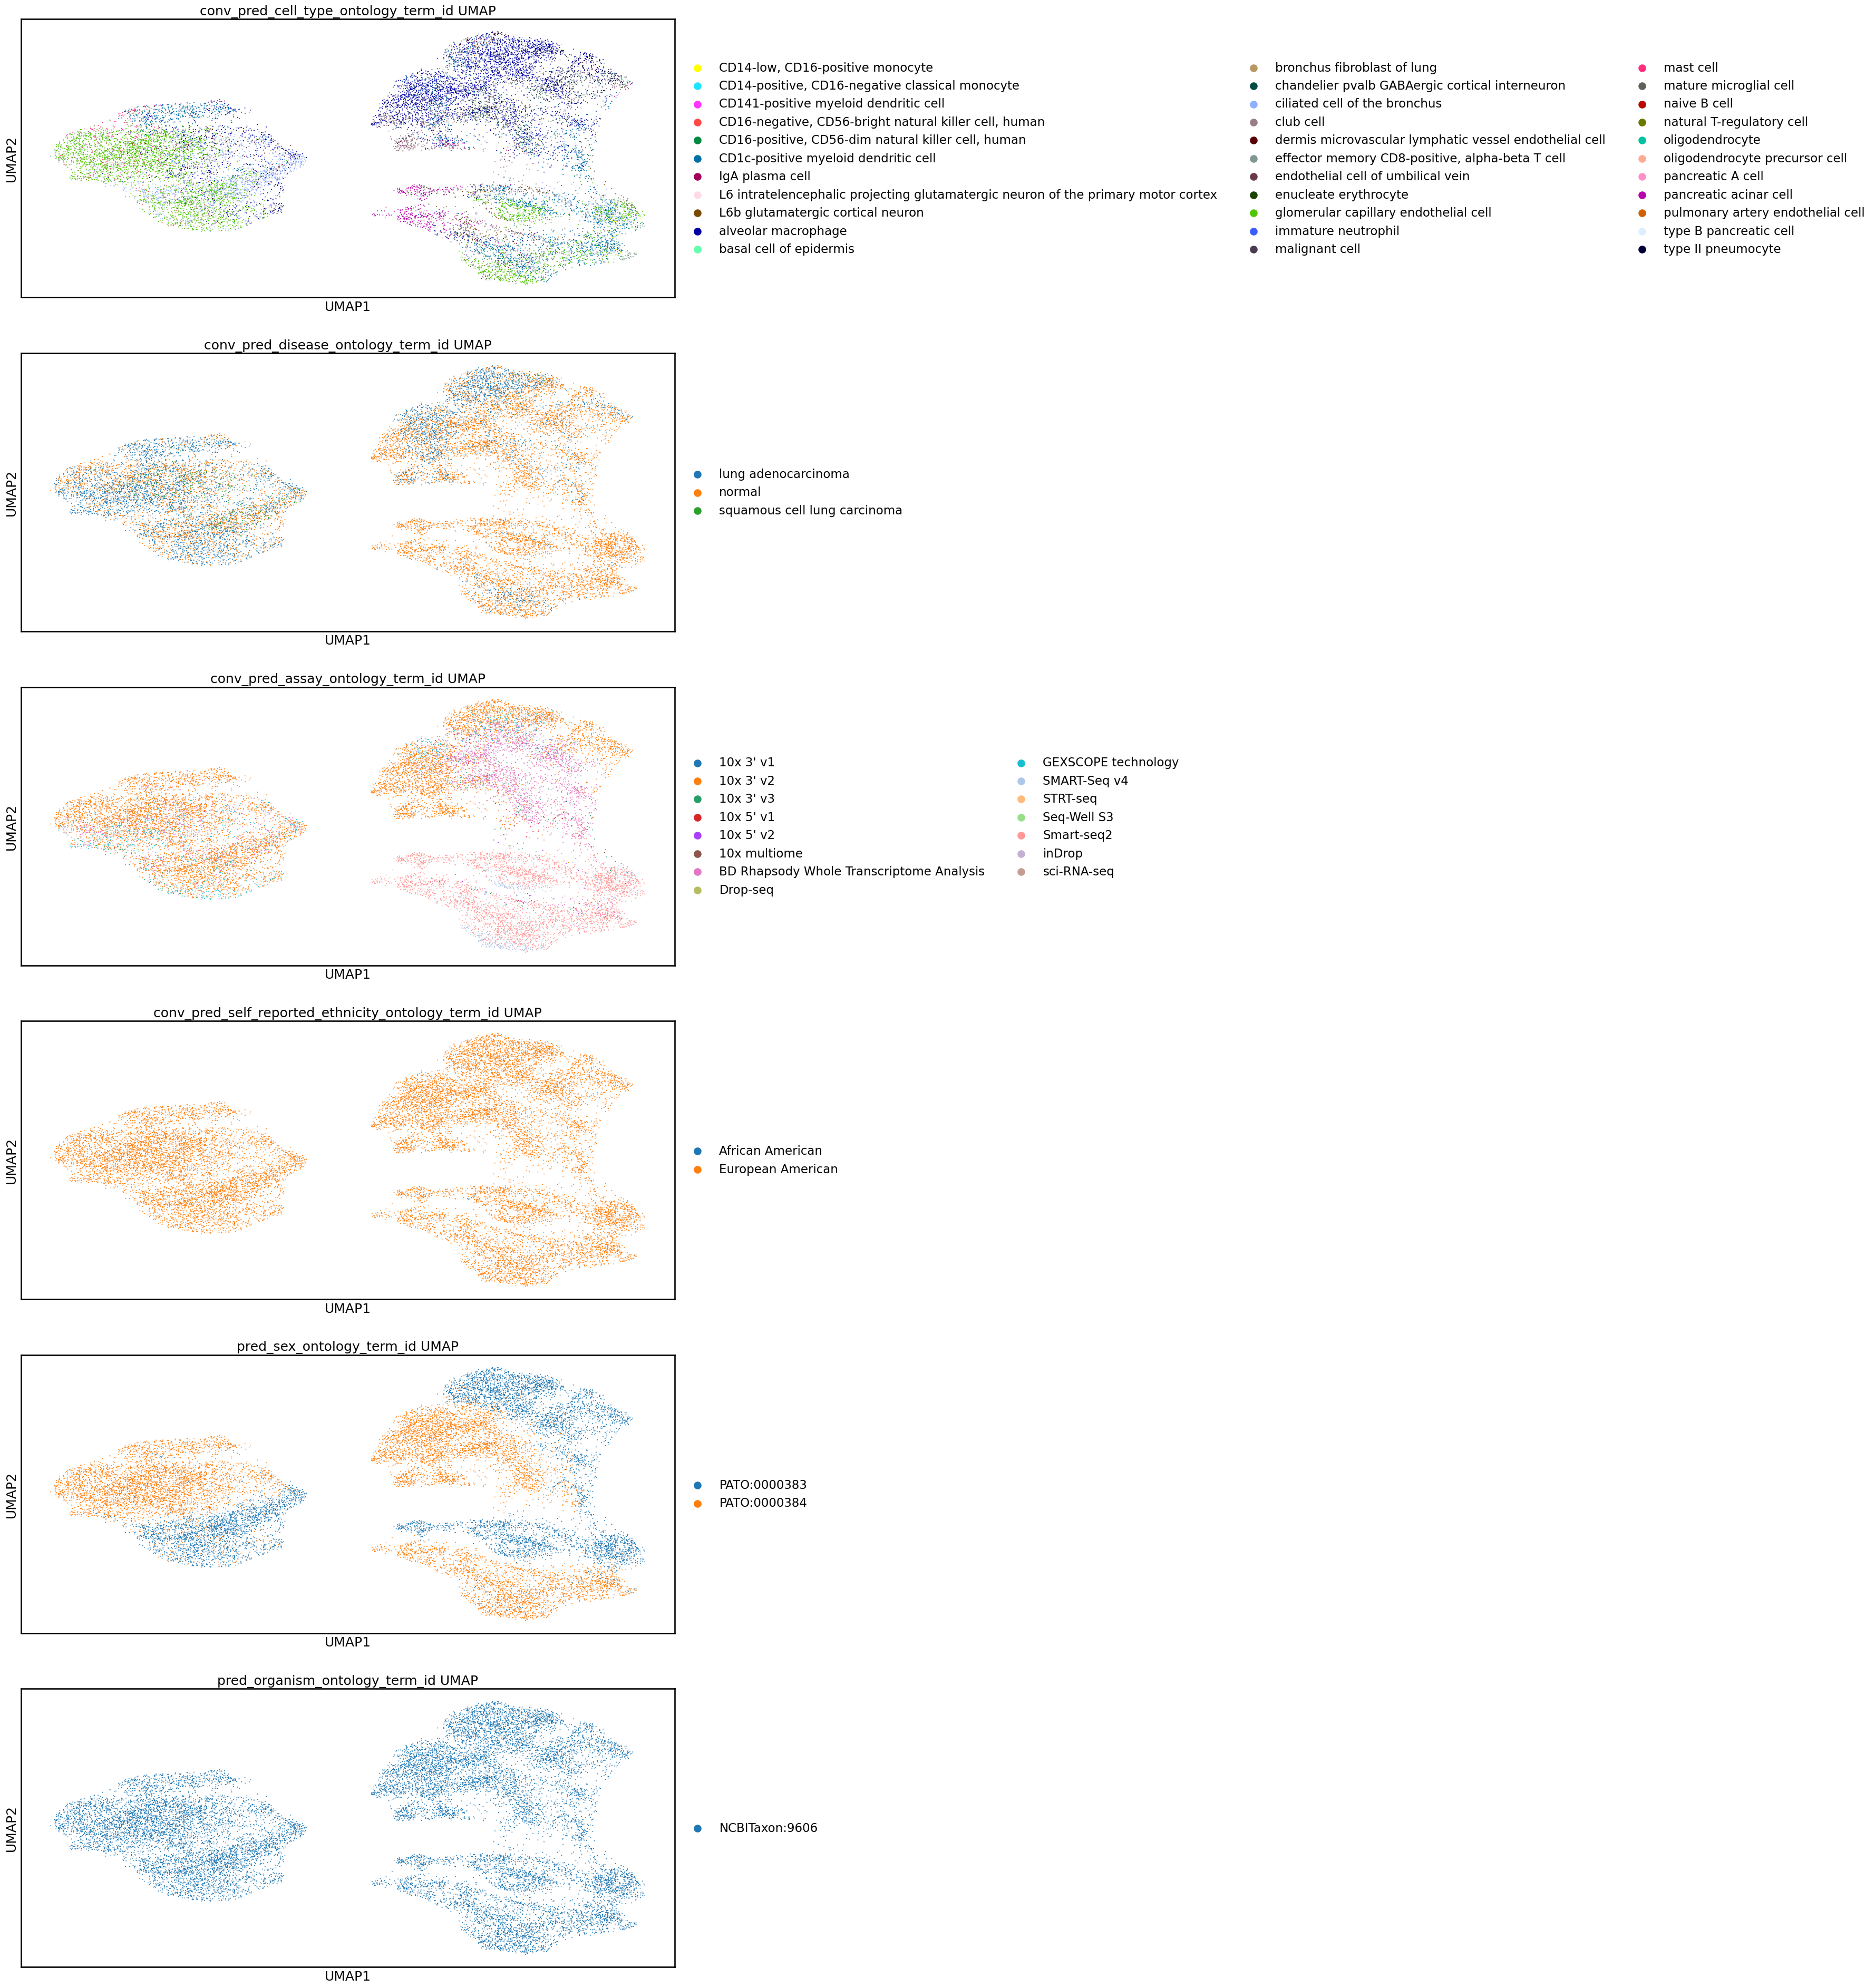

couldn't log to tensorboard
couldn't log to wandb
metrics for this dataset of size: 16382
     organism_ontology_term_id
     accuracy: 1.0
 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 64 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id', 'sprint_leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

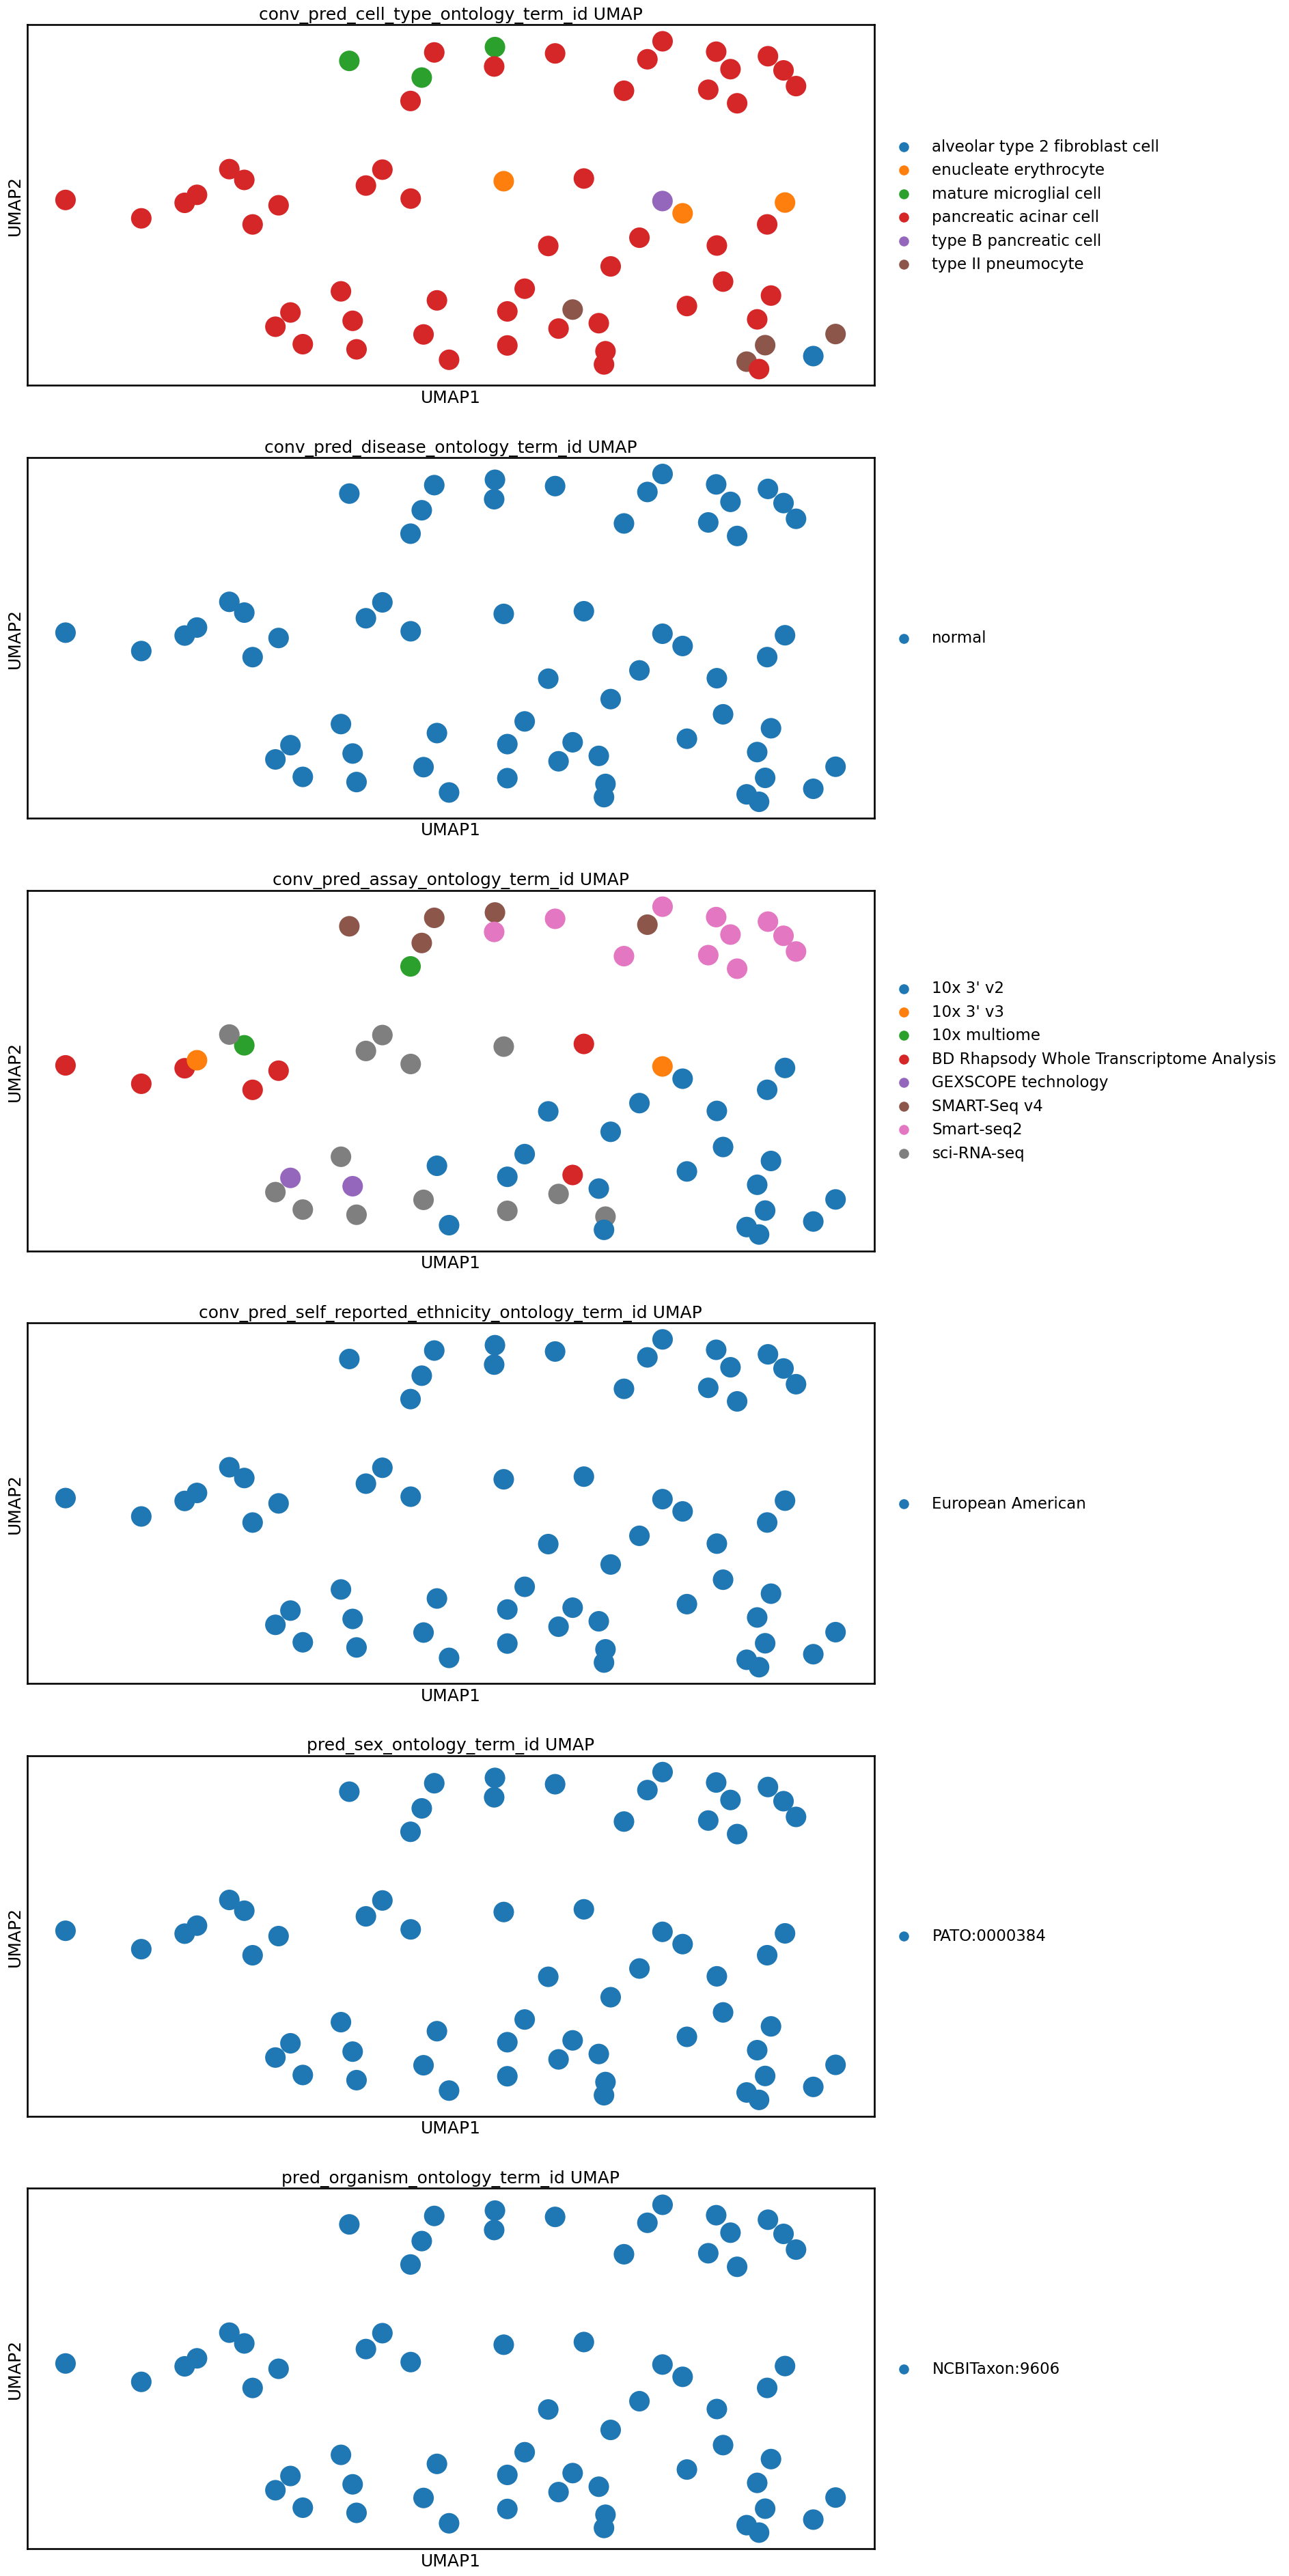

couldn't log to tensorboard
couldn't log to wandb


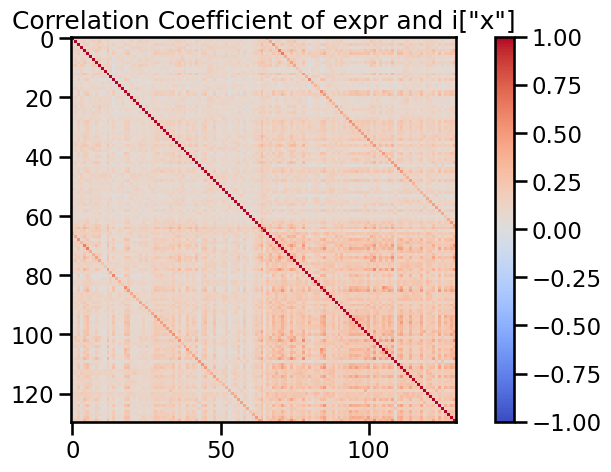

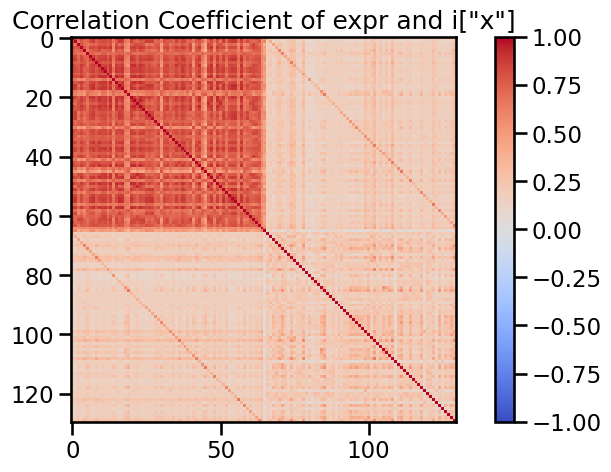

In [ ]:
embed_adata, metrics = embedder(adata.copy())

In [ ]:
metrics

{'organism_ontology_term_id_accuracy': 1.0,
 'recons_corr': 0.4288601369095814,
 'mean_regress': 0.17260434702244554}

In [ ]:
sc.pp.pca(embed_adata)

In [ ]:
from scib_metrics.benchmark import Benchmarker


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedo

In [ ]:
bm = Benchmarker(
    embed_adata,
    batch_key="tech",
    label_key="celltype",
    embedding_obsm_keys=["X_pca", "scprint"],
    n_jobs=6,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-04-07 15:06:21,269:INFO - isolated labels: no more than 4 batches per label
2024-04-07 15:06:21,363:INFO - Unable to initialize backend 'cuda': 
2024-04-07 15:06:21,365:INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-04-07 15:06:21,404:INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-04-07 15:06:21,406:WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.

Metrics:  60%|██████    | 6/10 [00:55<00:27,  6.95s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:  70%|███████   | 7/10 [01:12<00:30, 10.12s/it, Batch correction: graph_connectivity]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-04-07 15:07:34,735:INFO - isolated labels: no more than 4 batches per label

Metrics:  60%|██████    | 6/10 [04:09<01:40, 25.04s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.v

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:  70%|███████   | 7/10 [04:23<01:04, 21.41s/it, Batch correction: graph_connectivity]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|██████ | 9/10 [04:24<00:11, 11.38s/it, Batch correction: pcr_comparison]██████████| 2/2 [05:37<00:00, 185.77s/it]██████████| 2/2 [05:37<00:00, 168.93s/it]

                                                                                         

In [ ]:
df = bm.get_results(min_max_scale=False)

In [ ]:
metrics.update(df.T.to_dict()['scprint'])

In [ ]:
embed_adata

AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id', 'sprint_leiden', 'cell_type_ontology_term_id'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id

... storing 'organism_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desi

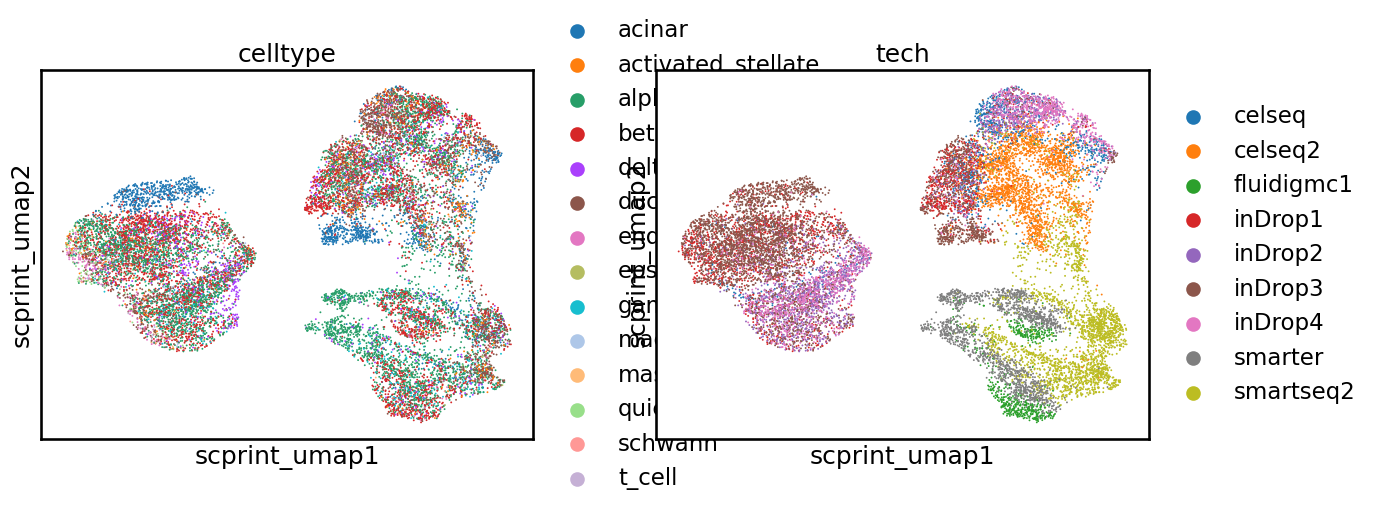

In [ ]:
sc.pl.embedding(embed_adata, basis="scprint_umap", color=['celltype', 'tech'])

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


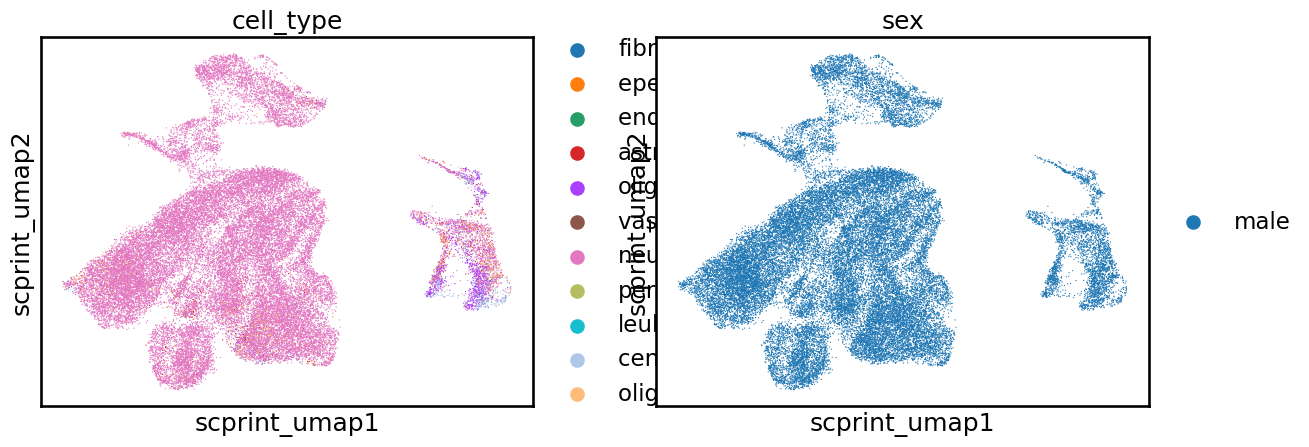

In [ ]:
sc.pl.embedding(embed_adata, basis="scprint_umap", color=['cell_type', 'sex'])

In [ ]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint

In [ ]:
embed_adata

In [ ]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [ ]:
preprocessor = Preprocessor(subset_hvg=1000, use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)

In [ ]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(adata.copy())

In [ ]:
set(adata.obs.cell_type)

{'astrocyte',
 'central nervous system macrophage',
 'endothelial cell',
 'ependymal cell',
 'fibroblast',
 'leukocyte',
 'neuron',
 'oligodendrocyte',
 'oligodendrocyte precursor cell',
 'pericyte',
 'vascular associated smooth muscle cell'}

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

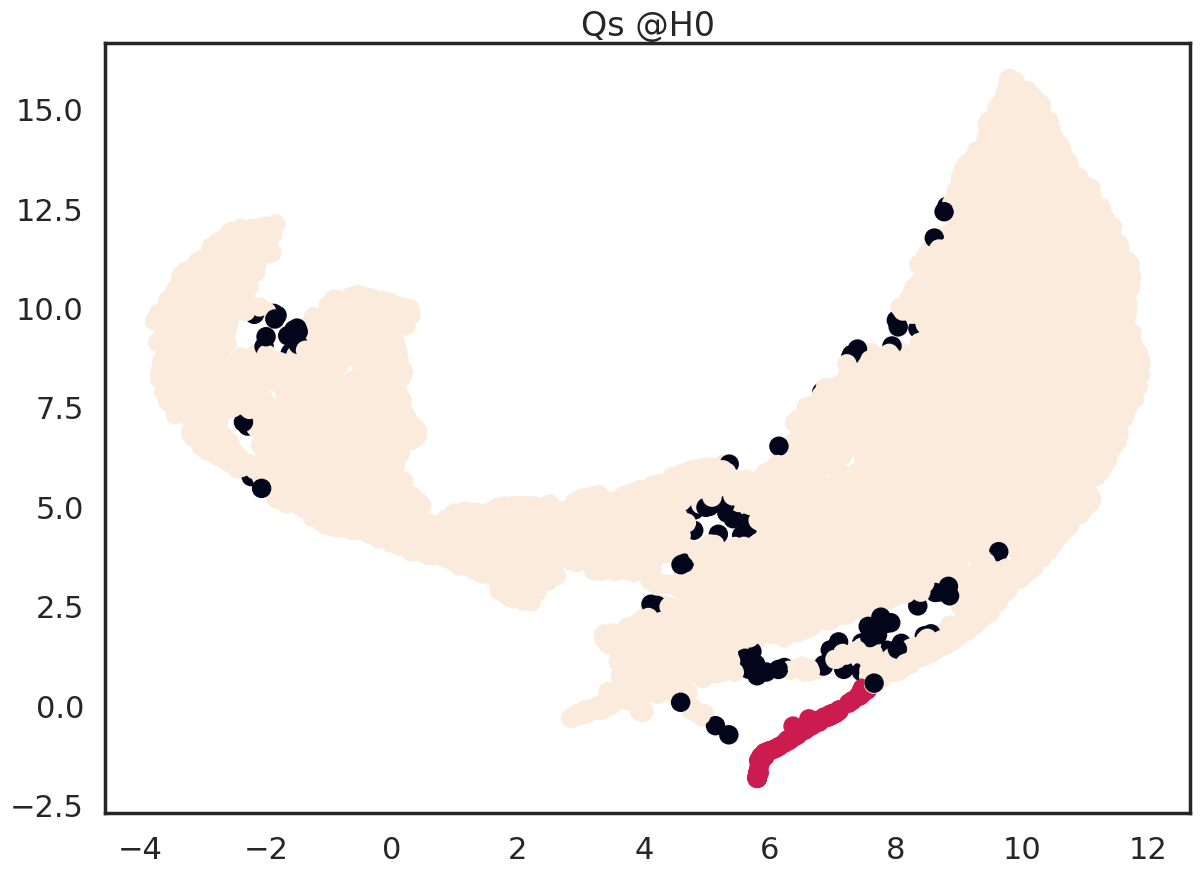

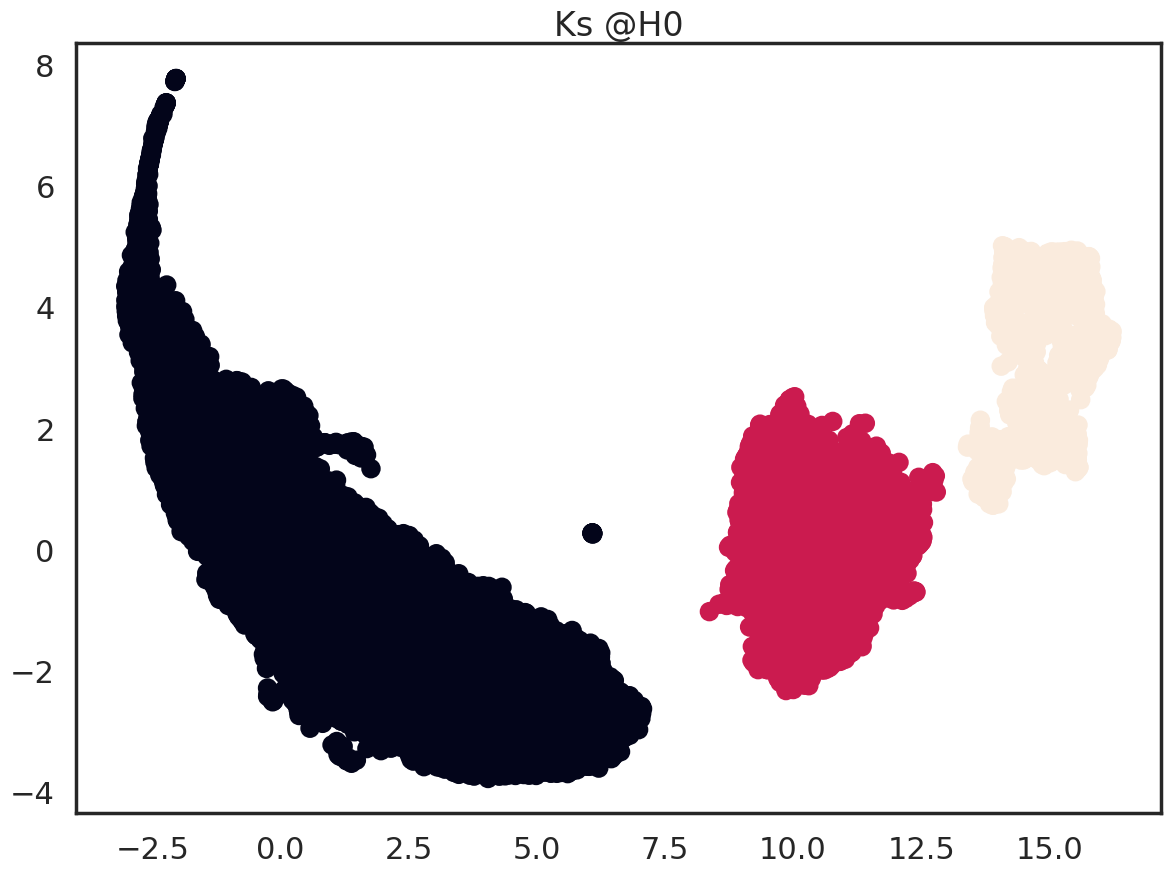

avg link count: 362102841, sparsity: 1.0



In [ ]:
grn_inferer = GRNfer(model, adata,
    how="random expr",
    preprocess="softmax",
    head_agg='max',
    cell_agg="mean",
    filtration="none",
    max_cells=128,
    #k=
    #genes=
    #known_grn
)
grn = grn_inferer(cell_type="astrocyte", layer=3)

base enrichment
Top central genes: []


2024-04-04 18:13:39,092 [WARNING] Duplicated values found in preranked stats: 99.99% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['celltype.gmt__Beta cells', 'celltype.gmt__Gamma (PP) cells', 'celltype.gmt__Alpha cells']


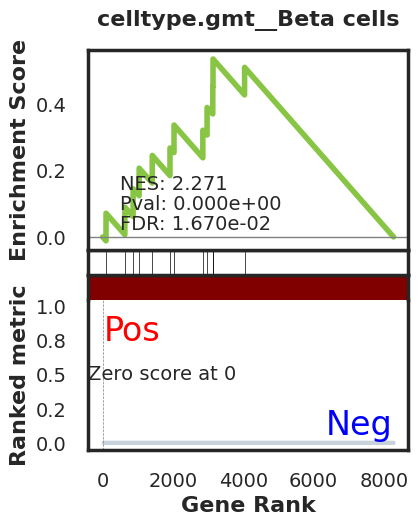

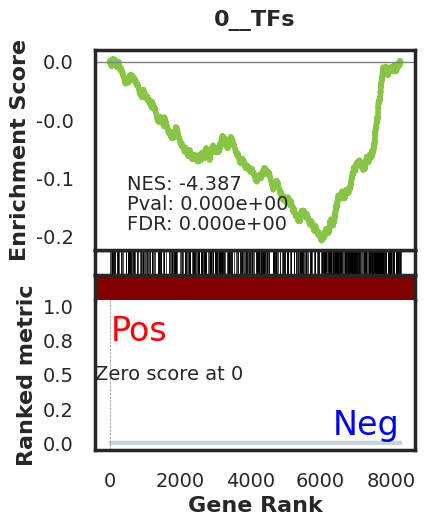

2024-04-04 18:13:44,684 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


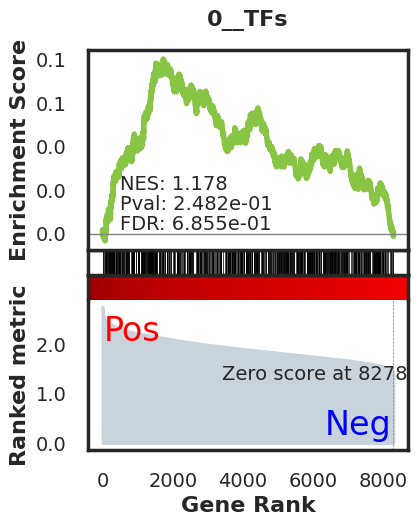

_________________________________________
TF specific enrichment


2024-04-04 18:13:49,151:INFO - Downloading and generating Enrichr library gene sets...
2024-04-04 18:13:49,155:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-04 18:13:49,432:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-04 18:13:49,459 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:13:50,116 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:13:50,762 [WARNING] Duplicated values found in preranked stats: 0.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:13:51,409 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, whic

found!  0__CEBPB
0    1.357914
Name: NES, dtype: object




2024-04-04 18:13:59,961 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:00,650 [WARNING] Duplicated values found in preranked stats: 0.16% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:01,351 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:02,037 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:02,670 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:03,348 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be

found!  0__CEBPZ
0    1.648277
Name: NES, dtype: object




2024-04-04 18:14:07,549 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__XRCC4
0    1.327982
Name: NES, dtype: object




2024-04-04 18:14:08,254 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:08,918 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:09,552 [WARNING] Duplicated values found in preranked stats: 0.24% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:10,219 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:10,865 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:11,588 [WARNING] Duplicated values found in preranked stats: 0.05% of genes
The order of those genes will be

found!  0__SETDB1
0    1.190378
Name: NES, dtype: object




2024-04-04 18:14:17,695 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:18,413 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:19,075 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:19,758 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:20,439 [WARNING] Duplicated values found in preranked stats: 0.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 18:14:21,126 [WARNING] Duplicated values found in preranked stats: 0.05% of genes
The order of those genes will be

_________________________________________
found some significant results for  7.142857142857143 % TFs

omnipath overlap
intersection of 5843 genes
intersection pct: 0.7057615654064501
precision:  0.0025023061982419868 
recall:  1.0 
random recall: 1.0


100%|██████████| 49/49 [00:07<00:00,  6.18it/s]


Area Under Precision-Recall Curve (AUPRC):  -0.002018148408261571
random precision is:  0.0025023061982419868


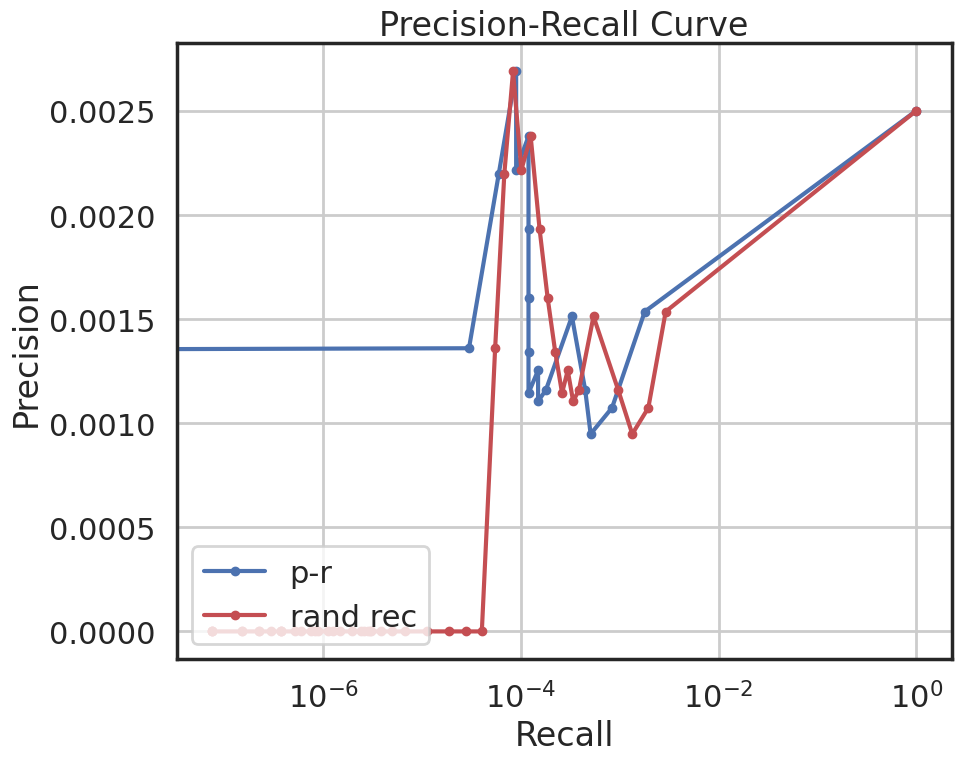

In [ ]:
#astro 128
BenGRN(grn).scprint_benchmark()

base enrichment
Top central genes: []


2024-04-04 17:57:09,799 [WARNING] Duplicated values found in preranked stats: 99.98% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['celltype.gmt__Gamma (PP) cells', 'celltype.gmt__Beta cells']


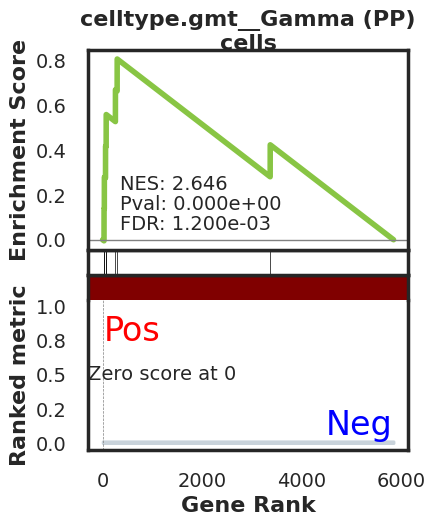

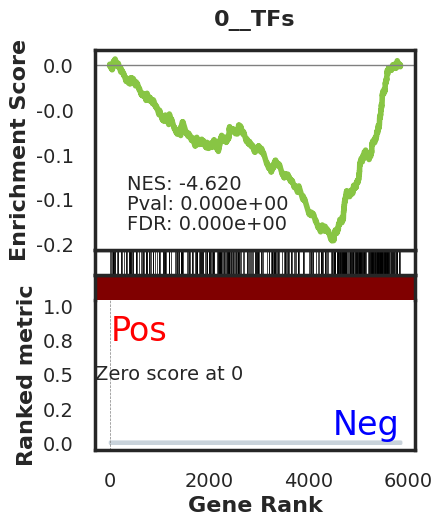

2024-04-04 17:57:13,926 [WARNING] Duplicated values found in preranked stats: 0.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['celltype.gmt__Neural Progenitor cells']


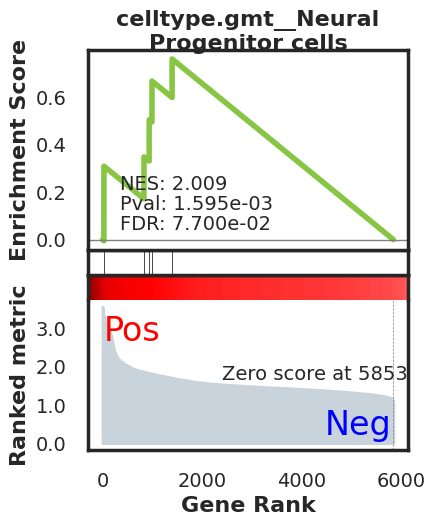

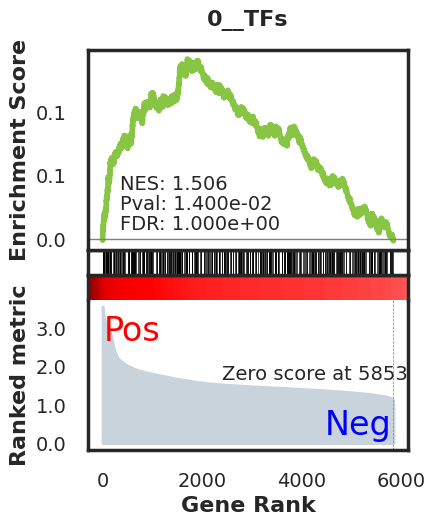

_________________________________________
TF specific enrichment


2024-04-04 17:57:17,962:INFO - Downloading and generating Enrichr library gene sets...
2024-04-04 17:57:17,975:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-04 17:57:18,253:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-04 17:57:18,278 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:18,855 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:19,305 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:20,309 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, whic

found!  0__STAT2
0    1.037828
Name: NES, dtype: object




2024-04-04 17:57:21,265 [WARNING] Duplicated values found in preranked stats: 0.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:21,780 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__CEBPB
0    1.042231
Name: NES, dtype: object




2024-04-04 17:57:22,279 [WARNING] Duplicated values found in preranked stats: 0.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:22,800 [WARNING] Duplicated values found in preranked stats: 0.24% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:23,275 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:23,754 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:24,255 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__JUND
0    1.016045
Name: NES, dtype: object




2024-04-04 17:57:24,777 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:25,268 [WARNING] Duplicated values found in preranked stats: 0.26% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:25,772 [WARNING] Duplicated values found in preranked stats: 0.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:26,299 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:26,798 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:57:27,712 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be

_________________________________________
found some significant results for  9.090909090909092 % TFs

omnipath overlap
intersection of 4158 genes
intersection pct: 0.7102835667919372
precision:  0.0029690253895669557 
recall:  1.0 
random recall: 1.0


100%|██████████| 49/49 [00:03<00:00, 13.16it/s]


Area Under Precision-Recall Curve (AUPRC):  -0.002570763365160671
random precision is:  0.0029690253895669557


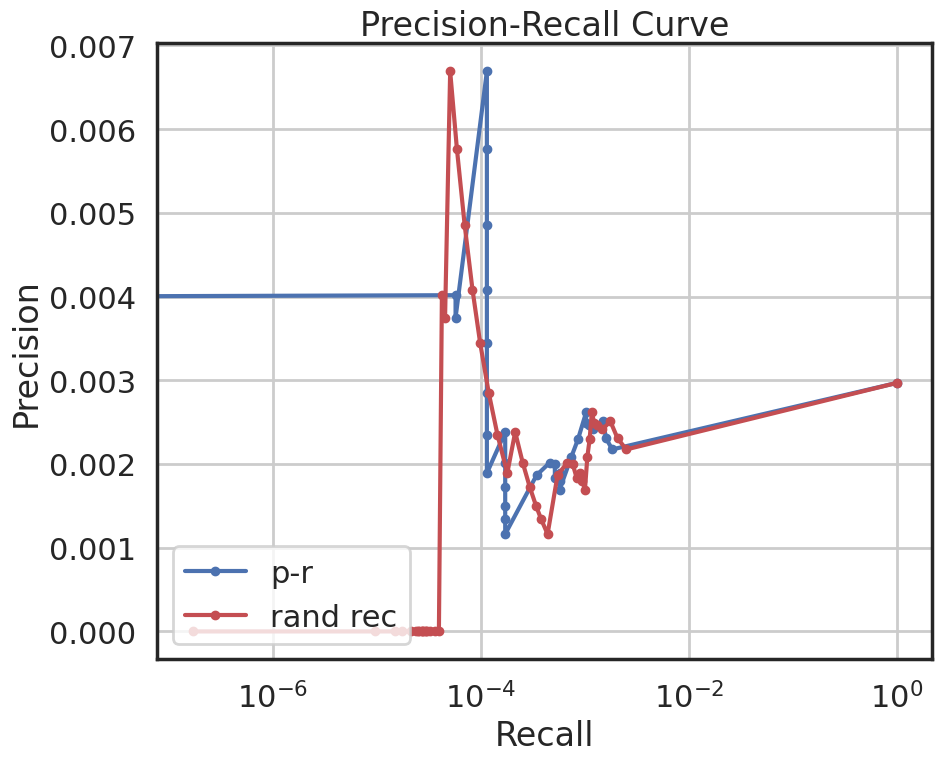

In [ ]:
#astro 64
BenGRN(grn).scprint_benchmark()

base enrichment
Top central genes: []


2024-04-04 17:46:51,241 [WARNING] Duplicated values found in preranked stats: 3.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


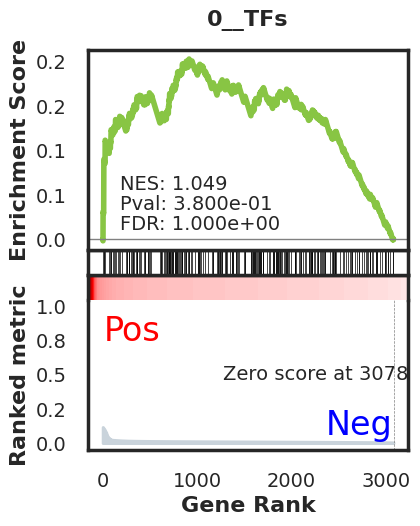

2024-04-04 17:46:52,562 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


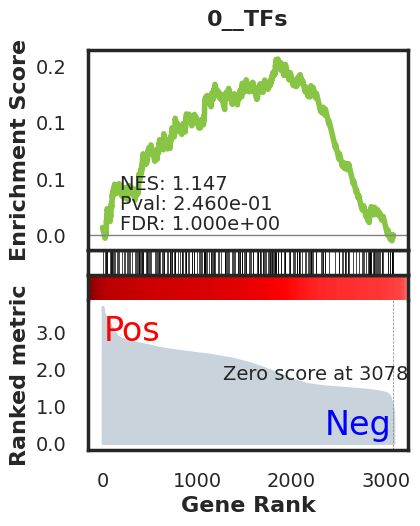

_________________________________________
TF specific enrichment


2024-04-04 17:46:54,227:INFO - Downloading and generating Enrichr library gene sets...
2024-04-04 17:46:54,230:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-04 17:46:54,456:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-04 17:46:54,467 [WARNING] Duplicated values found in preranked stats: 98.54% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:54,691 [WARNING] Duplicated values found in preranked stats: 97.63% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:54,921 [WARNING] Duplicated values found in preranked stats: 97.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:55,162 [WARNING] Duplicated values found in preranked stats: 97.21% of genes
The order of those genes will be arbitrary, 

found!  0__NRF1
0    1.016794
Name: NES, dtype: object




2024-04-04 17:46:56,075 [WARNING] Duplicated values found in preranked stats: 92.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:56,333 [WARNING] Duplicated values found in preranked stats: 98.54% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:56,563 [WARNING] Duplicated values found in preranked stats: 96.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:56,804 [WARNING] Duplicated values found in preranked stats: 99.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:57,032 [WARNING] Duplicated values found in preranked stats: 98.60% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:57,236 [WARNING] Duplicated values found in preranked stats: 97.63% of genes
The order of those genes w

2024-04-04 17:46:57,442 [WARNING] Duplicated values found in preranked stats: 97.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:57,673 [WARNING] Duplicated values found in preranked stats: 97.21% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:57,898 [WARNING] Duplicated values found in preranked stats: 98.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:58,126 [WARNING] Duplicated values found in preranked stats: 98.57% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:58,358 [WARNING] Duplicated values found in preranked stats: 97.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:46:58,566 [WARNING] Duplicated values found in preranked stats: 98.57% of genes
The order of those genes w

_________________________________________
found some significant results for  3.8461538461538463 % TFs

omnipath overlap
intersection of 2207 genes
intersection pct: 0.716791165962975
precision:  0.004011802464023191 
recall:  0.02967643116982577 
random recall: 0.031772503741714773


100%|██████████| 49/49 [00:01<00:00, 32.51it/s]


Area Under Precision-Recall Curve (AUPRC):  -9.903008021259535e-05
random precision is:  0.0042951596190852126


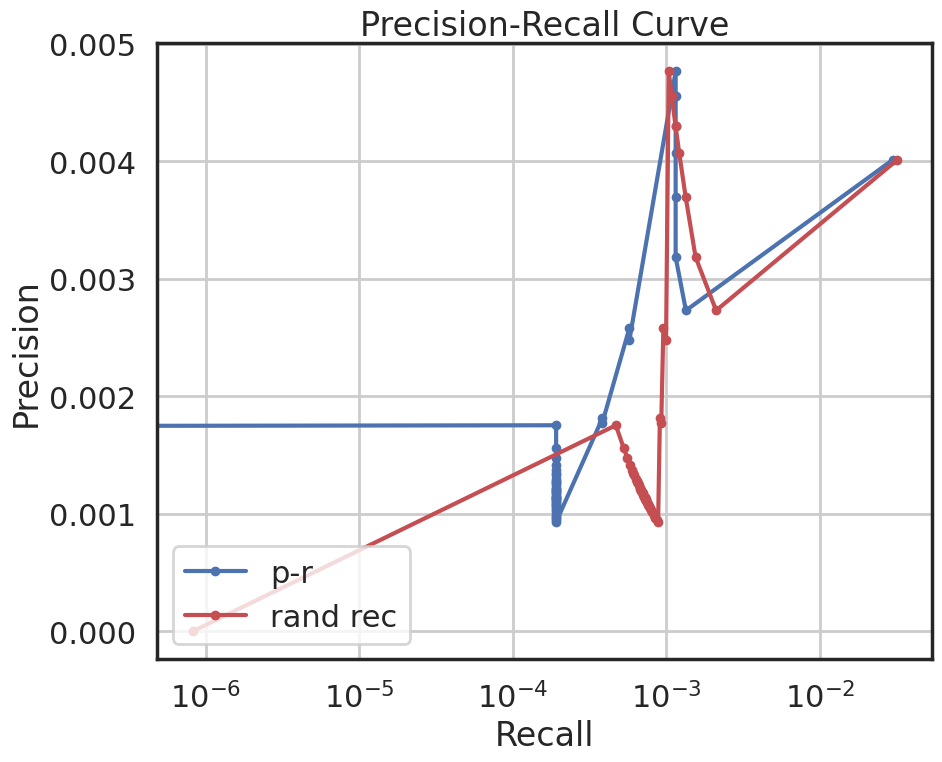

In [ ]:
#astro
BenGRN(grn).scprint_benchmark()

# oligo

In [ ]:
model.noise, model.do_denoise

([0.3], False)

In [ ]:
model.predict_depth_mult=3

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

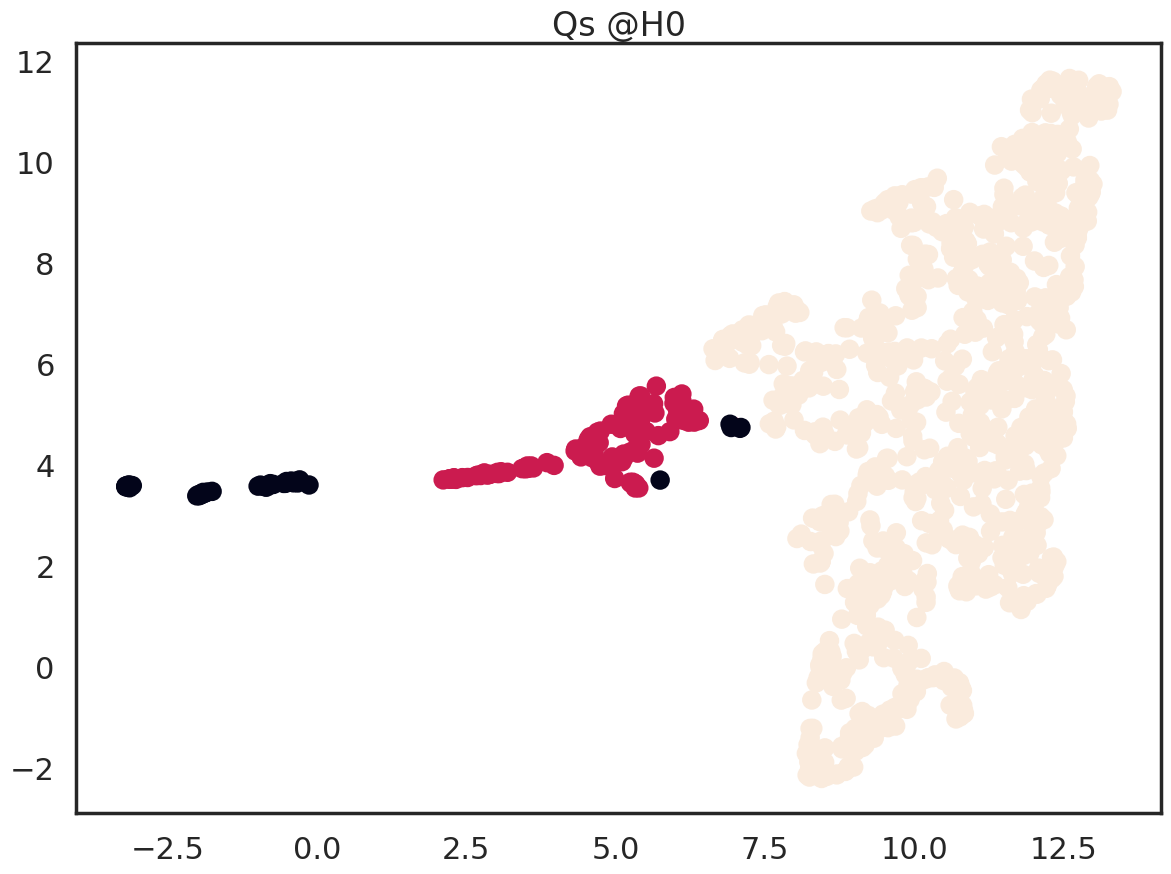

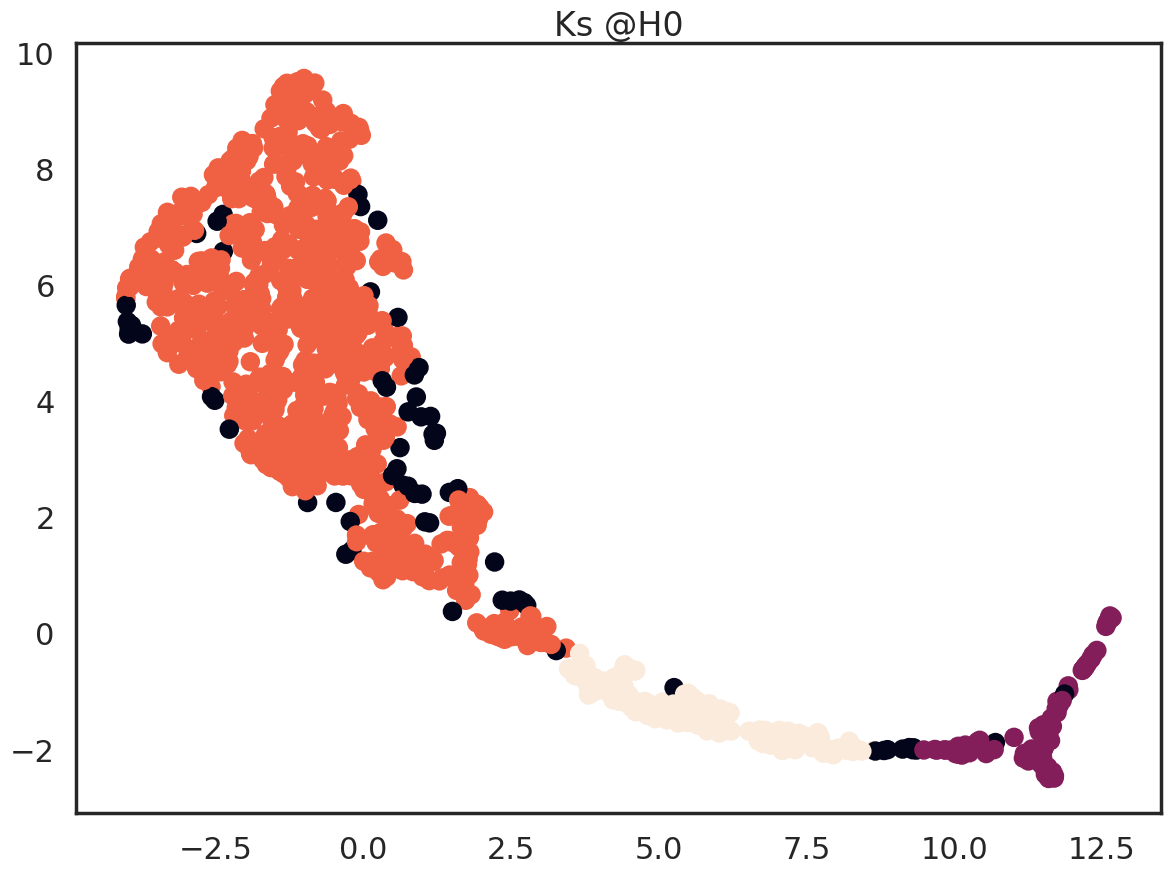

avg link count: 1605289, sparsity: 1.0



In [ ]:
# only a few cells
grn_inferer = GRNfer(model, adata,
    how="most var across",
    preprocess="softmax",
    head_agg='max',
    cell_agg="mean",
    filtration="none",
    forward_mode="denoise",
    #max_cells=64,
    #k=
    #genes=
    #known_grn
)
grn = grn_inferer(cell_type="oligodendrocyte precursor cell", layer=3)

base enrichment
Top central genes: []


2024-04-05 18:12:29,146 [WARNING] Duplicated values found in preranked stats: 99.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


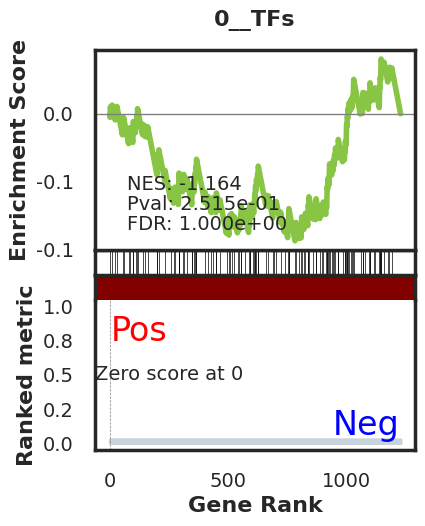

2024-04-05 18:12:29,854 [WARNING] Duplicated values found in preranked stats: 63.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


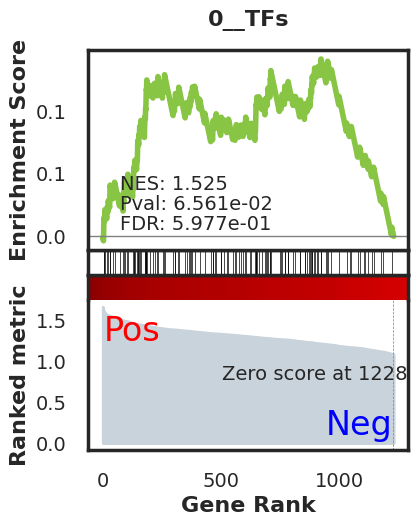

_________________________________________
TF specific enrichment


2024-04-05 18:12:31,164:INFO - Downloading and generating Enrichr library gene sets...
2024-04-05 18:12:31,166:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-05 18:12:31,344:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-05 18:12:31,352 [WARNING] Duplicated values found in preranked stats: 55.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-05 18:12:31,440 [WARNING] Duplicated values found in preranked stats: 57.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__TCF12
0    1.699862
Name: NES, dtype: object




2024-04-05 18:12:31,537 [WARNING] Duplicated values found in preranked stats: 55.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__TCF7L2
0    1.454017
Name: NES, dtype: object




2024-04-05 18:12:31,649 [WARNING] Duplicated values found in preranked stats: 55.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-05 18:12:31,755 [WARNING] Duplicated values found in preranked stats: 57.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


_________________________________________
found some significant results for  40.0 % TFs

omnipath overlap
intersection of 874 genes
intersection pct: 0.7105691056910569
precision:  0.008849470312884947 
recall:  1.0 
random recall: 1.0



100%|██████████| 49/49 [00:02<00:00, 19.01it/s]


Area Under Precision-Recall Curve (AUPRC):  -0.010390211452658824
random precision is:  0.008849470312884947


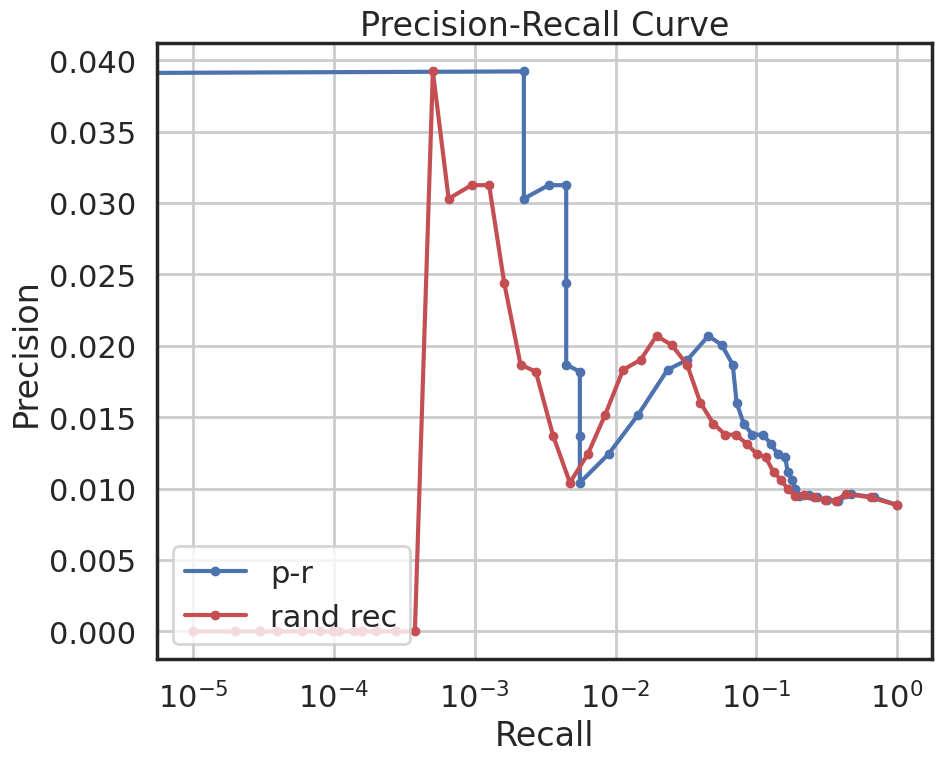

In [ ]:
#most var across & denoise
BenGRN(grn).scprint_benchmark()

base enrichment
Top central genes: []


2024-04-05 17:47:00,528 [WARNING] Duplicated values found in preranked stats: 99.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


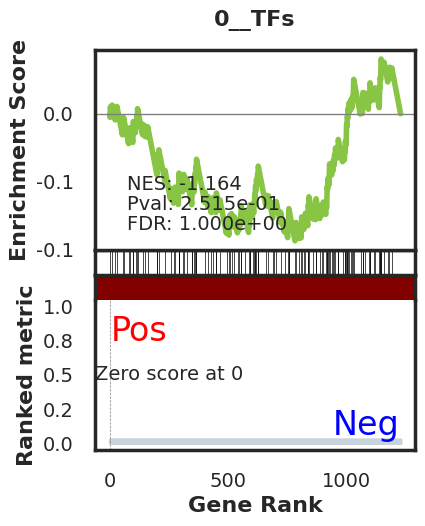

2024-04-05 17:47:01,215 [WARNING] Duplicated values found in preranked stats: 63.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


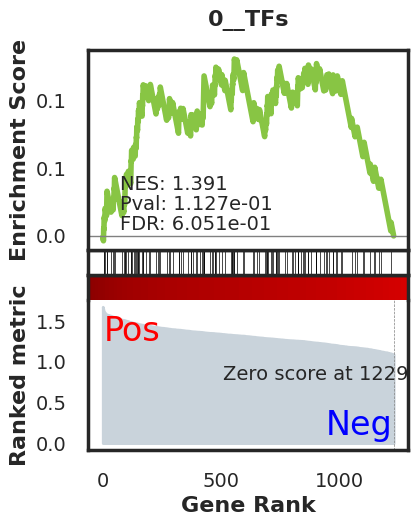

_________________________________________
TF specific enrichment


2024-04-05 17:47:02,535:INFO - Downloading and generating Enrichr library gene sets...
2024-04-05 17:47:02,538:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-05 17:47:02,723:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-05 17:47:02,732 [WARNING] Duplicated values found in preranked stats: 51.46% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-05 17:47:02,824 [WARNING] Duplicated values found in preranked stats: 55.69% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__TCF12
0    1.686586
Name: NES, dtype: object




2024-04-05 17:47:02,936 [WARNING] Duplicated values found in preranked stats: 51.46% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__TCF7L2
0    1.492582
Name: NES, dtype: object




2024-04-05 17:47:03,087 [WARNING] Duplicated values found in preranked stats: 51.46% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__TCF7L2
0    1.402092
Name: NES, dtype: object




2024-04-05 17:47:03,233 [WARNING] Duplicated values found in preranked stats: 55.69% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


_________________________________________
found some significant results for  60.0 % TFs

omnipath overlap
intersection of 874 genes
intersection pct: 0.7105691056910569
precision:  0.008849470312884947 
recall:  1.0 
random recall: 1.0


100%|██████████| 49/49 [00:02<00:00, 22.53it/s]


Area Under Precision-Recall Curve (AUPRC):  -0.010168476167220384
random precision is:  0.008849470312884947


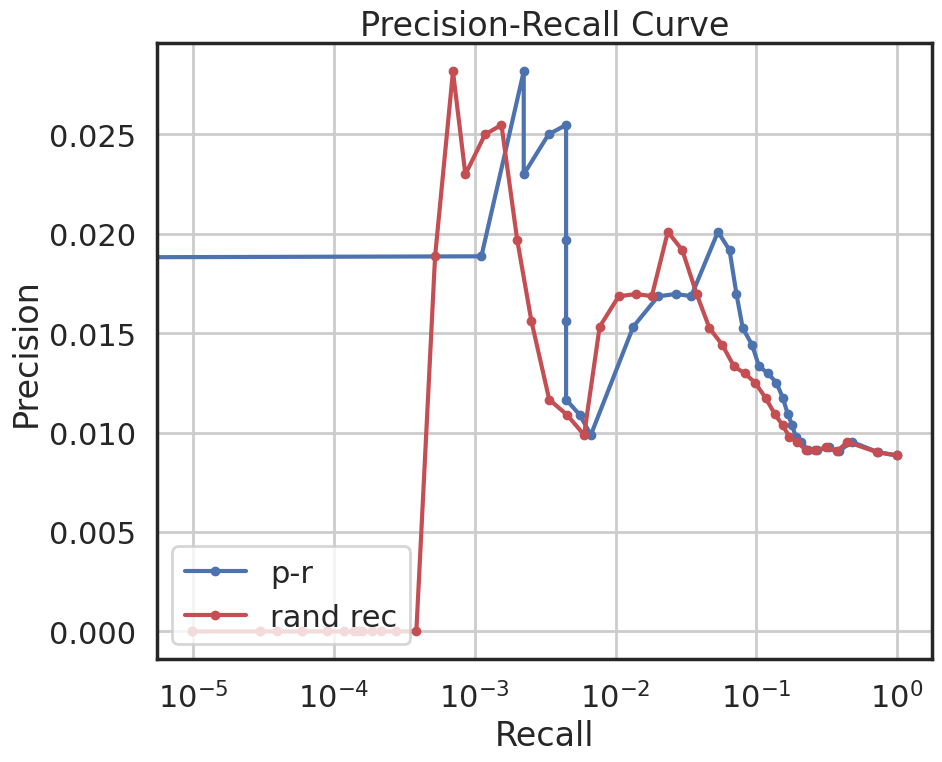

In [ ]:
#most var across 
BenGRN(grn).scprint_benchmark()

base enrichment
Top central genes: []


2024-04-05 14:44:11,452 [WARNING] Duplicated values found in preranked stats: 99.97% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


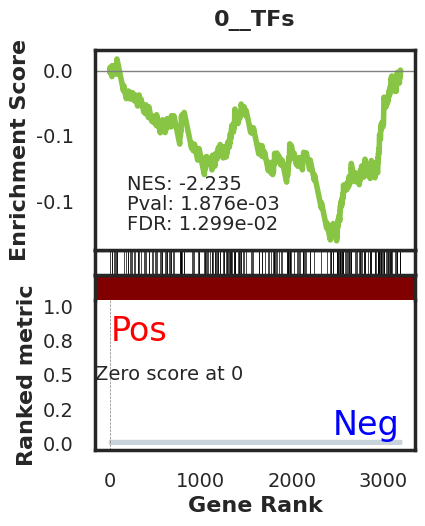

[]


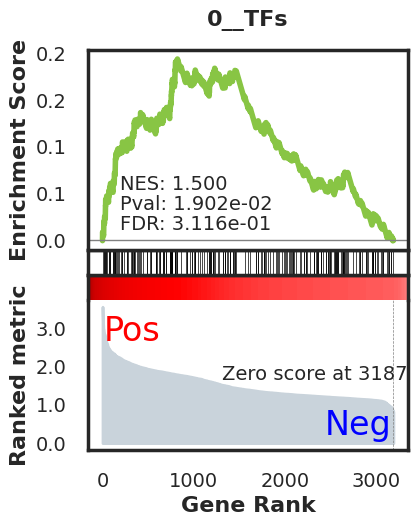

_________________________________________
TF specific enrichment


2024-04-05 14:44:14,088:INFO - Downloading and generating Enrichr library gene sets...
2024-04-05 14:44:14,100:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-05 14:44:14,344:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-05 14:44:14,356 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__BRF1
0    1.232654
Name: NES, dtype: object




2024-04-05 14:44:15,025 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-05 14:44:15,255 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-05 14:44:15,492 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-05 14:44:15,735 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-05 14:44:16,180 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-05 14:44:17,071 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be

found!  0__MAX
0    1.01749
Name: NES, dtype: object




2024-04-05 14:44:18,287 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-05 14:44:18,776 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


_________________________________________
found some significant results for  9.090909090909092 % TFs

omnipath overlap
intersection of 2317 genes
intersection pct: 0.7267879548306148
precision:  0.004059874647891679 
recall:  1.0 
random recall: 1.0


100%|██████████| 49/49 [00:00<00:00, 133.58it/s]


Area Under Precision-Recall Curve (AUPRC):  -0.0035371589047982605
random precision is:  0.004059874647891679


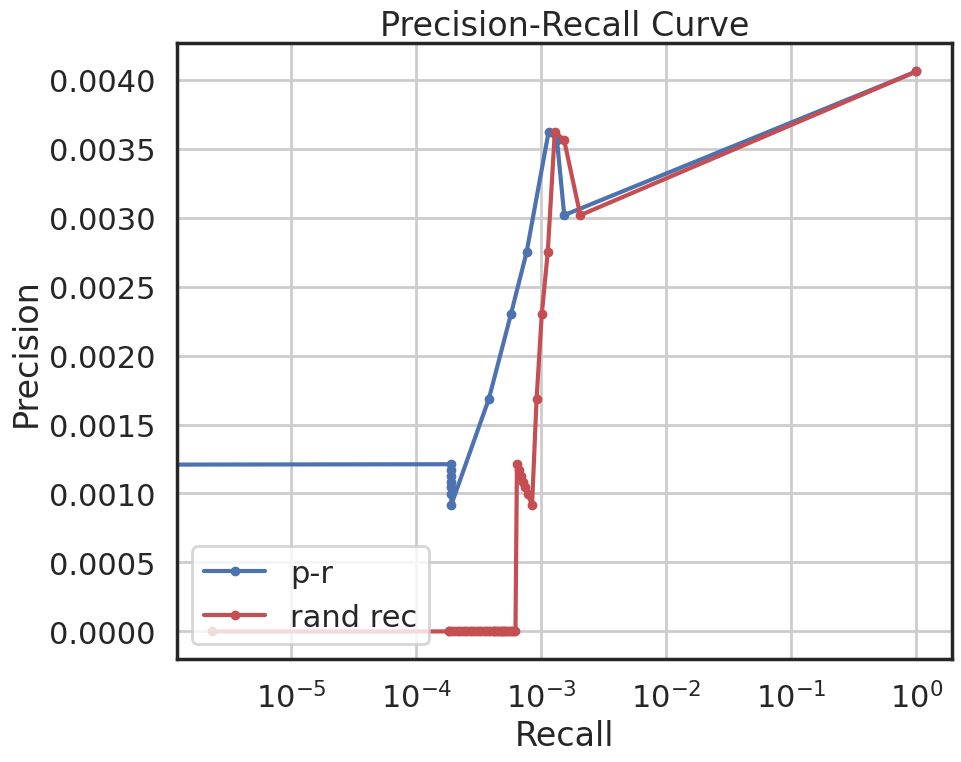

In [ ]:
# with 8 cells 
BenGRN(grn).scprint_benchmark()

base enrichment
Top central genes: []


2024-04-04 17:29:11,485 [WARNING] Duplicated values found in preranked stats: 8.73% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


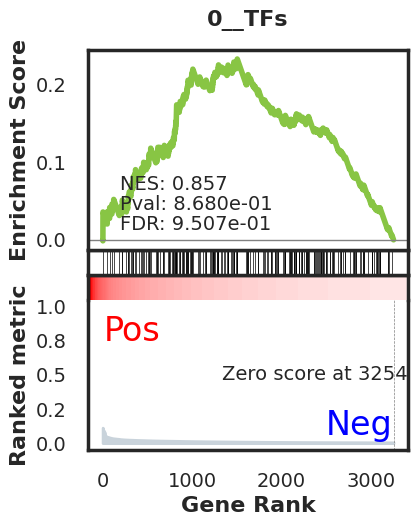

2024-04-04 17:29:12,485 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


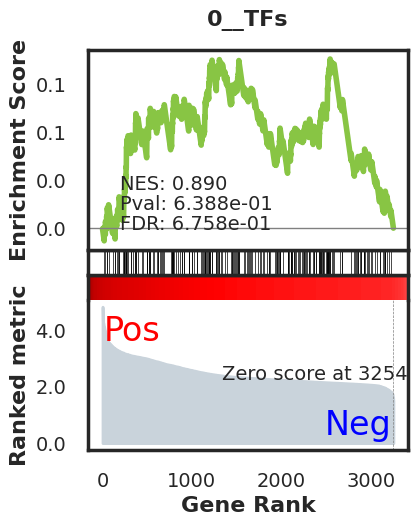

_________________________________________
TF specific enrichment


2024-04-04 17:29:14,253:INFO - Downloading and generating Enrichr library gene sets...
2024-04-04 17:29:14,257:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-04 17:29:14,571:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-04 17:29:14,584 [WARNING] Duplicated values found in preranked stats: 94.65% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:29:14,836 [WARNING] Duplicated values found in preranked stats: 94.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:29:15,087 [WARNING] Duplicated values found in preranked stats: 95.85% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:29:15,346 [WARNING] Duplicated values found in preranked stats: 99.11% of genes
The order of those genes will be arbitrary, 

found!  0__RAD21
0    1.004127
Name: NES, dtype: object




2024-04-04 17:29:19,379 [WARNING] Duplicated values found in preranked stats: 94.65% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:29:19,670 [WARNING] Duplicated values found in preranked stats: 98.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:29:19,945 [WARNING] Duplicated values found in preranked stats: 95.51% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__MAX
0    1.024979
Name: NES, dtype: object




2024-04-04 17:29:20,248 [WARNING] Duplicated values found in preranked stats: 98.65% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:29:20,554 [WARNING] Duplicated values found in preranked stats: 94.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:29:20,835 [WARNING] Duplicated values found in preranked stats: 98.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:29:21,092 [WARNING] Duplicated values found in preranked stats: 97.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-04 17:29:21,344 [WARNING] Duplicated values found in preranked stats: 72.32% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


_________________________________________
found some significant results for  6.451612903225806 % TFs

omnipath overlap
intersection of 2361 genes
intersection pct: 0.7253456221198157
precision:  0.007185547405596305 
recall:  0.08655104712041885 
random recall: 0.0528266415042892


100%|██████████| 49/49 [00:00<00:00, 62.70it/s]


Area Under Precision-Recall Curve (AUPRC):  -0.0007185127905151556
random precision is:  0.0043857162846266725


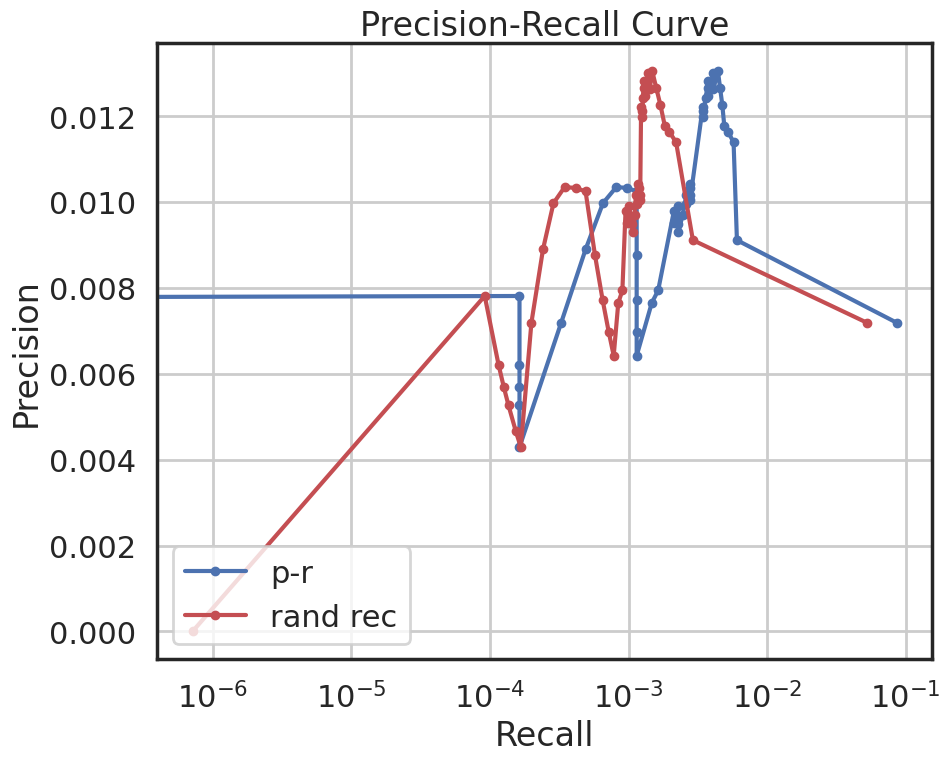

In [ ]:
#oligo prec
BenGRN(grn).scprint_benchmark()

# aggregation of all layers

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

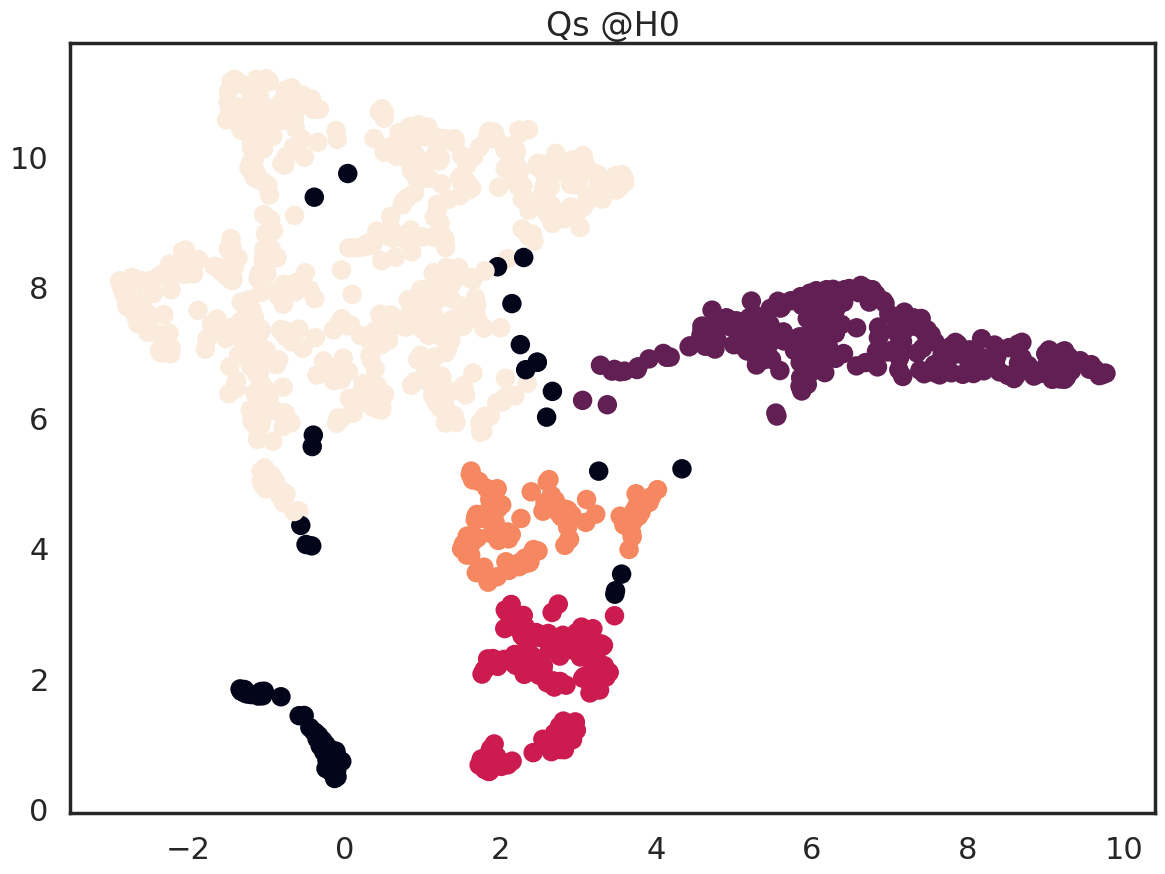

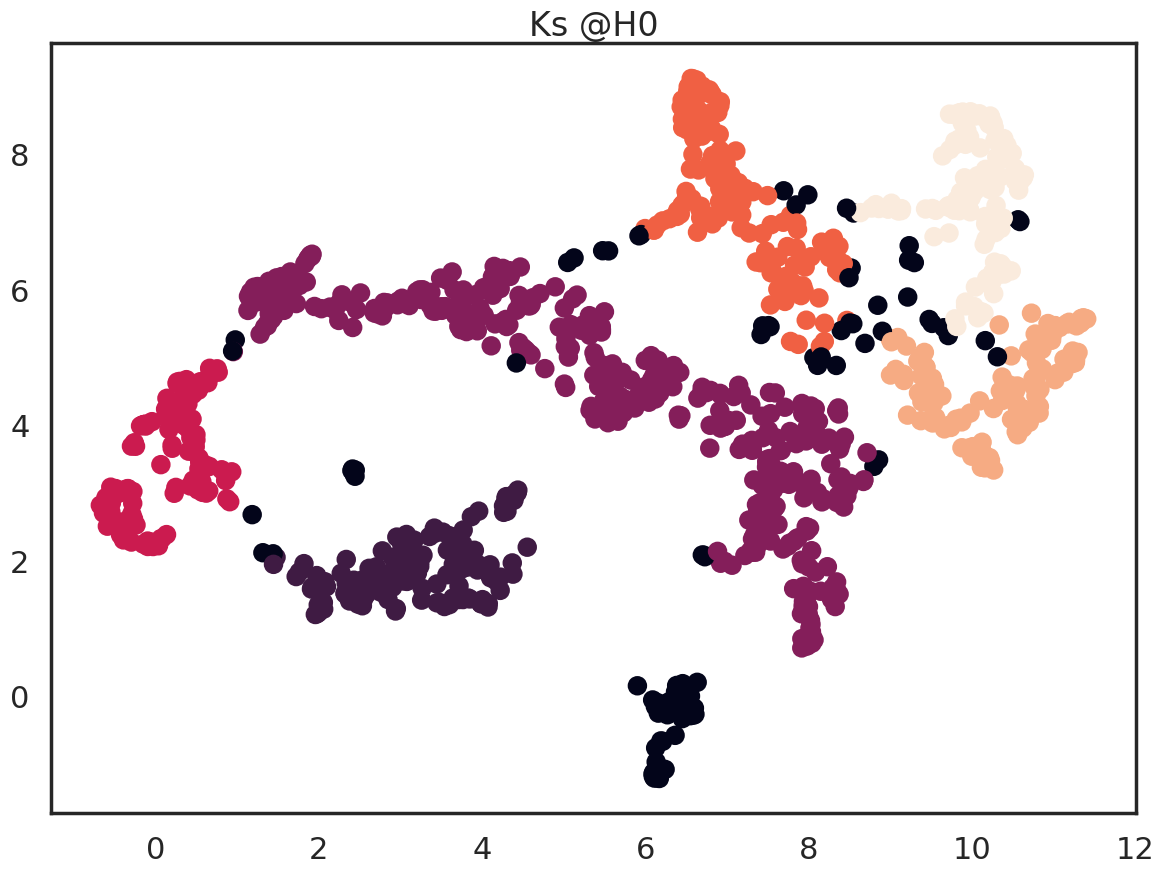

> /home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py(276)aggregate()
    274 
    275 /home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py(276)aggregate()
    274 
    275             pdb.set_trace()
--> 276             attn = attn.max(0)[0].detach().cpu().numpy()
    277         elif self.head_agg == "none":
    278             attn = attn.detach().cpu().numpy()

torch.Size([8, 1267, 1267])
torch.Size([8, 1267, 1267])
[0, 1, 2, 3]


In [ ]:
# only a few cells
grn_inferer = GRNfer(model, adata,
    how="most var across",
    preprocess="softmax",
    head_agg='max',
    cell_agg="mean",
    filtration="none",
    forward_mode="denoise",
    #max_cells=64,
    #k=
    #genes=
    #known_grn
)   
grn = grn_inferer(cell_type="oligodendrocyte precursor cell", layer=[0,1,2,3])

base enrichment
Top central genes: []


2024-04-05 18:12:29,146 [WARNING] Duplicated values found in preranked stats: 99.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


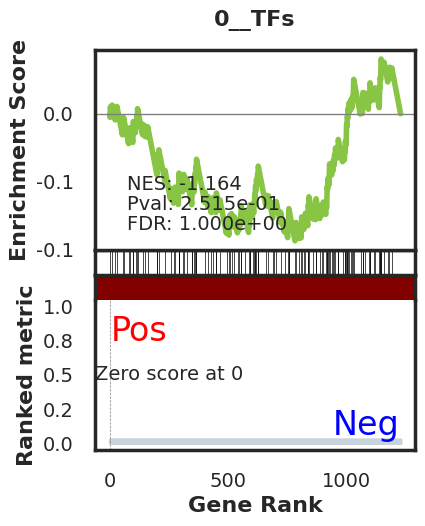

2024-04-05 18:12:29,854 [WARNING] Duplicated values found in preranked stats: 63.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


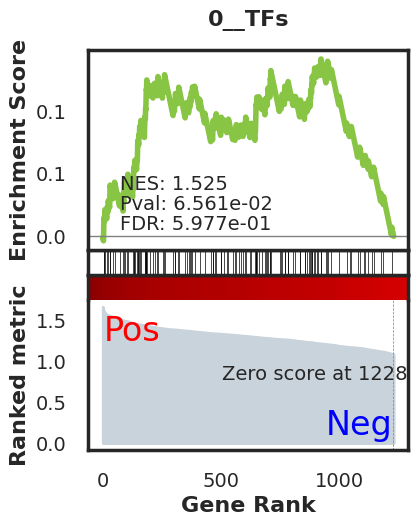

_________________________________________
TF specific enrichment


2024-04-05 18:12:31,164:INFO - Downloading and generating Enrichr library gene sets...
2024-04-05 18:12:31,166:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-05 18:12:31,344:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-05 18:12:31,352 [WARNING] Duplicated values found in preranked stats: 55.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-05 18:12:31,440 [WARNING] Duplicated values found in preranked stats: 57.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__TCF12
0    1.699862
Name: NES, dtype: object




2024-04-05 18:12:31,537 [WARNING] Duplicated values found in preranked stats: 55.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__TCF7L2
0    1.454017
Name: NES, dtype: object




2024-04-05 18:12:31,649 [WARNING] Duplicated values found in preranked stats: 55.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-05 18:12:31,755 [WARNING] Duplicated values found in preranked stats: 57.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


_________________________________________
found some significant results for  40.0 % TFs

omnipath overlap
intersection of 874 genes
intersection pct: 0.7105691056910569
precision:  0.008849470312884947 
recall:  1.0 
random recall: 1.0



100%|██████████| 49/49 [00:02<00:00, 19.01it/s]


Area Under Precision-Recall Curve (AUPRC):  -0.010390211452658824
random precision is:  0.008849470312884947


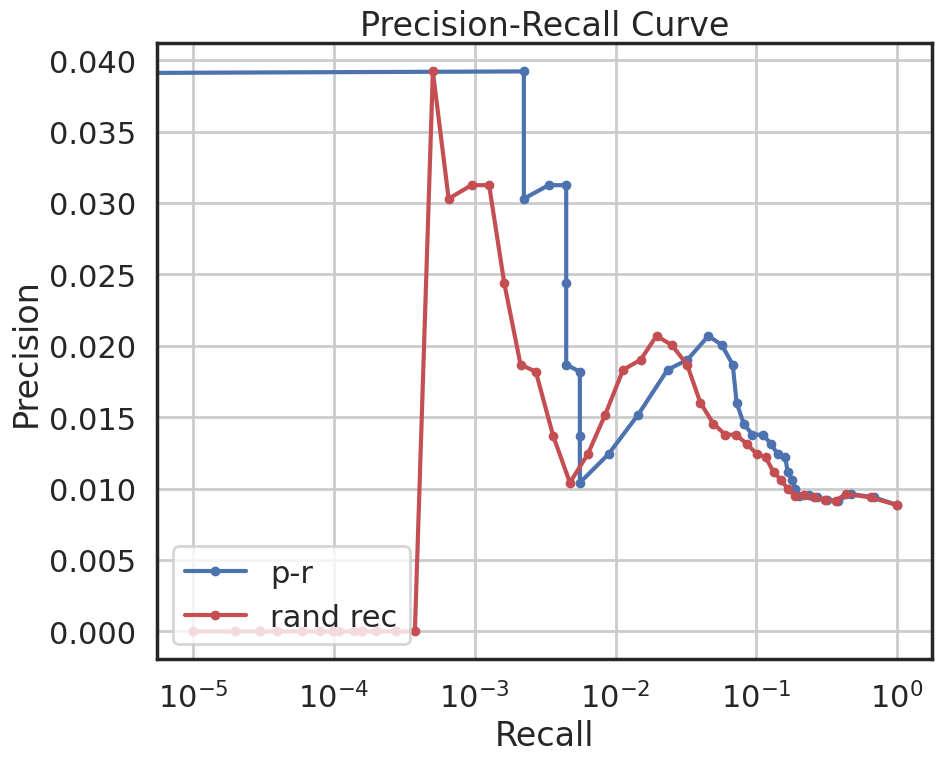

In [ ]:
#most var across & denoise
BenGRN(grn).scprint_benchmark()

## SROY

In [ ]:
preadata = get_sroy_gt(join="inner")
preadata

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:197: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


GRnnData object with n_obs × n_vars = 457 × 7813
    obs: 'dataset'
    varp: 'GRN'
    with a grn of 2817 elements

In [ ]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False, min_valid_genes_id=5000)

In [ ]:
preadata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(preadata.copy())
preadata.obs

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 457 renamining
filtered out 0 cells, 457 renamining
Removed 0 genes.
startin QC
Seeing 97 outliers (21.23% of total dataset):
done


dataset organism_ontology_term_id
CL100078088_L01_501     liu            NCBITaxon:9606
CL100078088_L01_502     liu            NCBITaxon:9606
CL100078088_L01_503     liu            NCBITaxon:9606
CL100078088_L01_507     liu            NCBITaxon:9606
CL100078088_L01_510     liu            NCBITaxon:9606
...                     ...                       ...
TGTAATCATCTG           chen            NCBITaxon:9606
GTTCTTCCTAGT           chen            NCBITaxon:9606
ATCCGTTCAACG           chen            NCBITaxon:9606
AAGCCTGGGGGC           chen            NCBITaxon:9606
CAGCTGGTGATG           chen            NCBITaxon:9606

[457 rows x 2 columns]

In [ ]:
grn_inferer = GRNfer(model, adata,
    how="most var within",
    preprocess="softmax",
    head_agg='none',
    cell_agg="mean",
    filtration="none",
    forward_mode="none",
    apc=True,
    symmetrize=True,
    max_cells=64,
    #k=
    #genes=
    #known_grn
)
#grn = grn_inferer(layer=list(range(model.nlayers))[:4])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7586


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

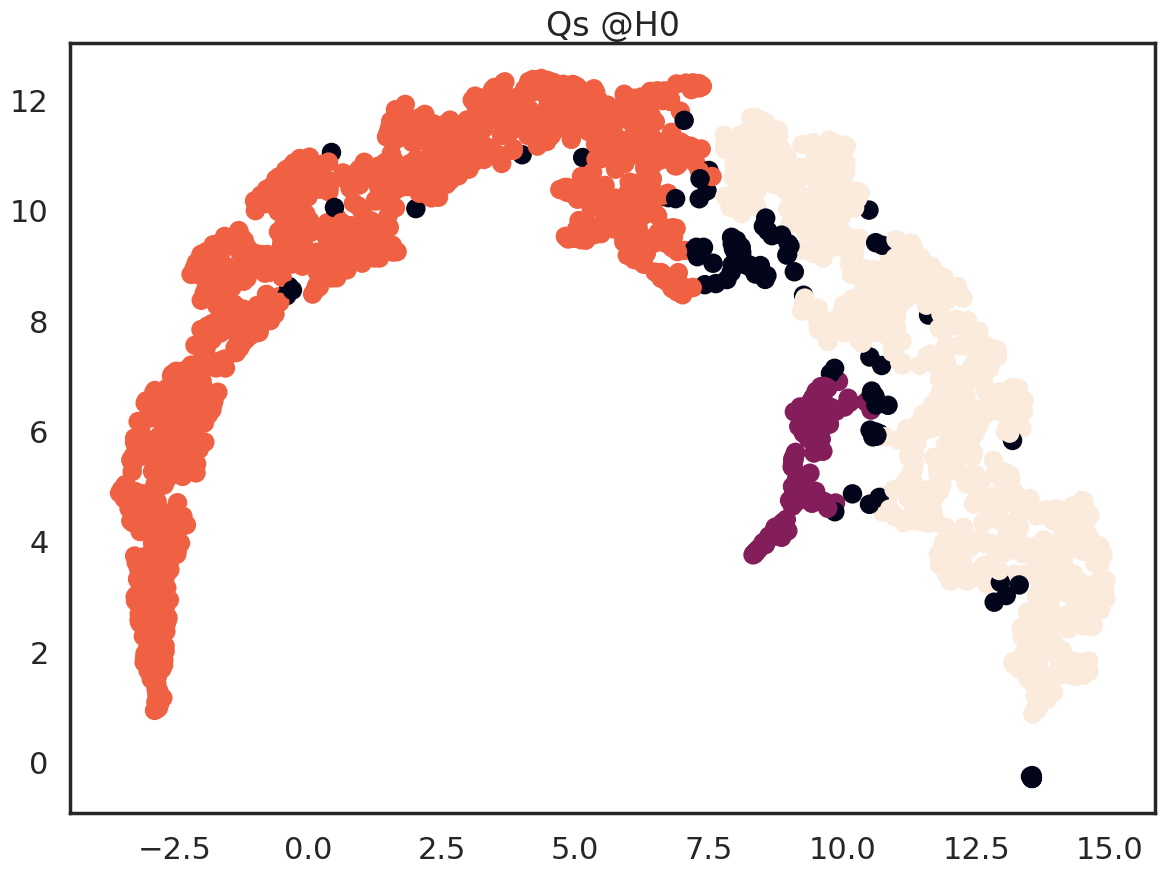

In [144]:
grn = grn_inferer.predict(layer=list(range(model.nlayers))[6:])
adj = grn_inferer.aggregate(grn_inferer.model.mean_attn)

In [97]:
adj = adj.reshape(-1, adj.shape[-2], adj.shape[-1]).T
loc = np.array((adata[:, adata.var.index.isin(grn_inferer.curr_genes)].X!=0).sum(0)>2)[0]
curr_genes = adata[:, adata.var.index.isin(np.array(grn_inferer.curr_genes)[loc].tolist())].var.symbol.tolist()
adj = adj[8:, 8:, :][loc, : ,:][:,loc,:]
np.save('adj.npy', adj)

In [138]:
adj = np.load("adj.npy")

In [143]:
adj[0,0]

array([-8.3752100e-05, -8.3752086e-05, -8.3752100e-05, -8.3752093e-05,
       -8.3752086e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
       -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
       -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
       -8.3752093e-05, -8.3752100e-05, -8.3752093e-05, -8.3752093e-05,
       -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
       -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752086e-05,
       -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
       -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752100e-05,
       -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
       -8.3752100e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
       -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05],
      dtype=float32)

In [102]:
len(intersection)

{'CTDSP2',
 'PLEKHA4',
 'ARAF',
 'MASTL',
 'PPP4R4',
 'L3MBTL1',
 'SEC23B',
 'MRPL28',
 'EPHB1',
 'GEMIN5',
 'AMMECR1',
 'LIMK2',
 'POLR3C',
 'GALE',
 'ABT1',
 'MYCBP2',
 'PLA2G15',
 'SHROOM2',
 'ZFYVE9',
 'TARBP1',
 'IFT43',
 'PI4KA',
 'ARFRP1',
 'CNKSR1',
 'ABLIM1',
 'MTX1',
 'ITPR1',
 'ARVCF',
 'UBE2Q2',
 'KIF5A',
 'PHKA1',
 'CCNH',
 'CD53',
 'CREM',
 'KLF10',
 'C2CD3',
 'ZNF354A',
 'ZCCHC14',
 'BDH2',
 'HERC5',
 'INVS',
 'ZNF251',
 'DUSP12',
 'TXNDC16',
 'ATAD3B',
 'HNRNPH1',
 'ATP6V1B2',
 'B4GALT3',
 'ST3GAL6',
 'RPS15A',
 'NFX1',
 'N6AMT1',
 'ZNF32',
 'SNX9',
 'SBDS',
 'CBLB',
 'IFT27',
 'GOLGA5',
 'SLC22A23',
 'JMJD6',
 'TRUB1',
 'MLLT3',
 'HMG20B',
 'BRD9',
 'XPO5',
 'ZSCAN9',
 'RLIM',
 'SDHAF1',
 'TUBA4A',
 'PLRG1',
 'GPR176',
 'LYPLA2',
 'IFRD1',
 'RPS21',
 'SIRT3',
 'ALKBH2',
 'MCM9',
 'CAV1',
 'RHOBTB1',
 'KIFAP3',
 'RPTOR',
 'RHOC',
 'GTF3C1',
 'COX7A2L',
 'AHNAK',
 'MT-ND2',
 'ASB1',
 'TRMT13',
 'TACC2',
 'TAF3',
 'NUDT4',
 'PROCR',
 'B3GNT2',
 'ANKRD37',
 'ZNF711',
 'TAO

In [100]:
varnames = set(gt.iloc[:, :2].values.flatten())
intersection = varnames & set(curr_genes)

loc = np.isin(curr_genes, np.array(list(intersection)))
curr_genes = np.array(curr_genes)[loc].tolist()
sadj = adj[:, loc, :][loc, :, :]

da = np.zeros((len(curr_genes), len(curr_genes)), dtype=np.float)
for i, j in gt.iloc[:,:2].values:
    if i in curr_genes and j in curr_genes:
        da[curr_genes.index(i), curr_genes.index(j)] = 1
        da[curr_genes.index(j), curr_genes.index(i)] = 1
print("true elem", da.sum())

/tmp/ipykernel_518805/1090870275.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(curr_genes), len(curr_genes)), dtype=np.float)


true elem 11997.0
 11997.0


In [101]:
from bengrn.base import get_GT_db
gt = get_GT_db(name="omnipath")

In [ ]:
from bengrn.base import train_classifier

ModuleNotFoundError: No module named 'benGRN'

In [131]:
grn = preadata.grn.loc[preadata.grn.sum(1)>0, preadata.grn.sum(0)>0]
grn = grn.loc[grn.index.isin(curr_genes), grn.columns.isin(curr_genes)]

In [135]:
adj.shape

(8862529, 48)

In [133]:
adj[[curr_genes.index(i) for i in grn.index], curr_genes.index(i) for i in grn.index]

array([[-8.3752100e-05, -8.3752086e-05, -8.3752100e-05, -8.3752093e-05,
        -8.3752086e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
        -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
        -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
        -8.3752093e-05, -8.3752100e-05, -8.3752093e-05, -8.3752093e-05,
        -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
        -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752086e-05,
        -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
        -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752100e-05,
        -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
        -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05,
        -8.3752093e-05, -8.3752093e-05, -8.3752093e-05, -8.3752093e-05],
       [-8.3752100e-05, -8.3752086e-05, -8.3752100e-05, -8.3752093e-05,
        -8.3752086e-05, -8.3752093e-05, -8.3752093e-05, -8.3752

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split


coef [[-0.10679221 -3.71924096 -1.07783935  0.          1.289061    6.0828743
   0.          0.          0.         -0.01958133  0.          0.
   8.1657771   0.          0.63212091  0.          0.         -3.18256713
   0.         -1.43330521  0.         -0.07867186  0.          0.
   0.          0.          0.         -1.47625468  0.          0.
  -1.35110312  0.          0.         -0.45304348  0.         -3.08639229
   7.5024553   2.04751472  0.         -2.05994266  1.51840704  0.
   1.10142467  0.          0.         -0.08907213  0.          0.        ]]
precision 0.047619047619047616
random precision 0.0027220603615717913
recall 0.0002144082332761578
predicted true 42.0
number of true 9328.0


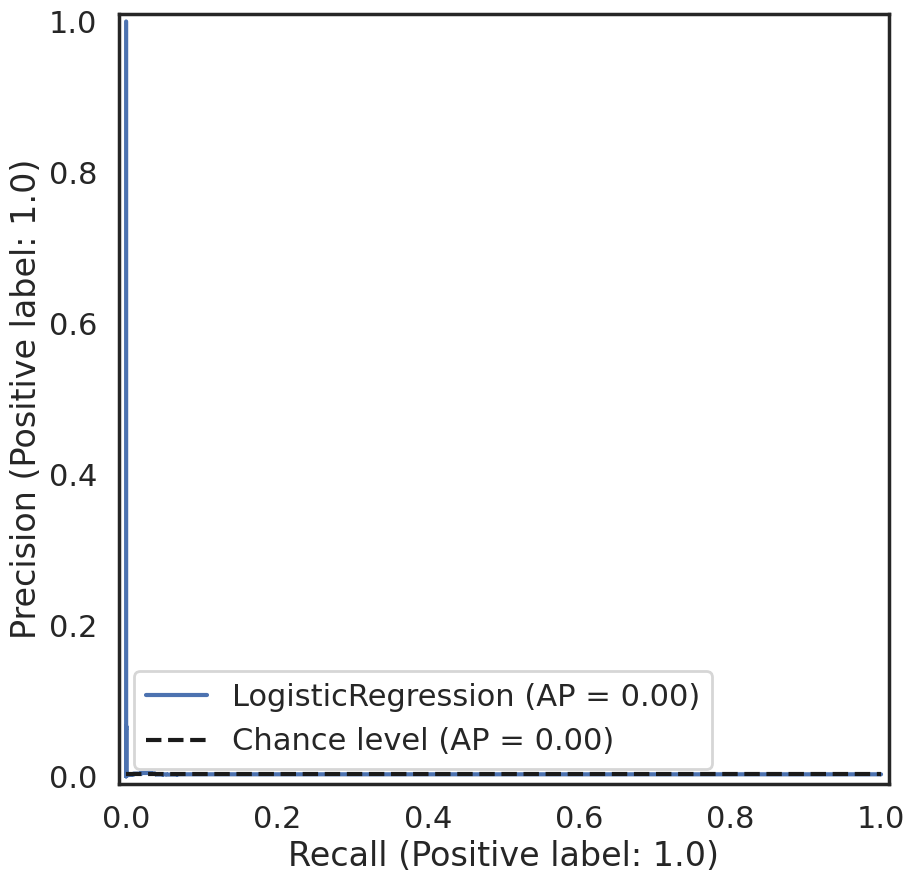

In [106]:
da = da.flatten()
sadj = sadj.reshape(-1, adj.shape[-1])


coef [[ 3.28888078e-01 -1.05386257e+01 -2.25542754e+00 -3.52661220e+00
  -1.26737236e+00  7.50750814e+00 -1.67289990e+00  4.24144084e-01
  -7.35941863e+02  2.75549767e-01  0.00000000e+00  0.00000000e+00
   7.21864271e+00  0.00000000e+00  1.08901889e+00  0.00000000e+00
   6.69362048e-01 -6.35711419e+00  0.00000000e+00 -4.02933650e+00
   0.00000000e+00 -1.09514410e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -8.29853924e-01  5.16950069e+00
   0.00000000e+00 -4.79775738e+00 -2.89342258e+00 -4.06019021e+00
   0.00000000e+00 -1.99129006e+00  0.00000000e+00 -1.11851096e+01
   6.81231417e+00  7.20190187e+00  0.00000000e+00 -1.95781443e+01
   8.30346746e-01  0.00000000e+00  1.99874041e+00  0.00000000e+00
   0.00000000e+00 -7.24330930e-02 -4.85599320e+00 -8.58875534e+02]]
precision 0.012276968407267965
random precision 0.002760819114428123
recall 0.011194029850746268
predicted true 6109.0
number of true 6700.0


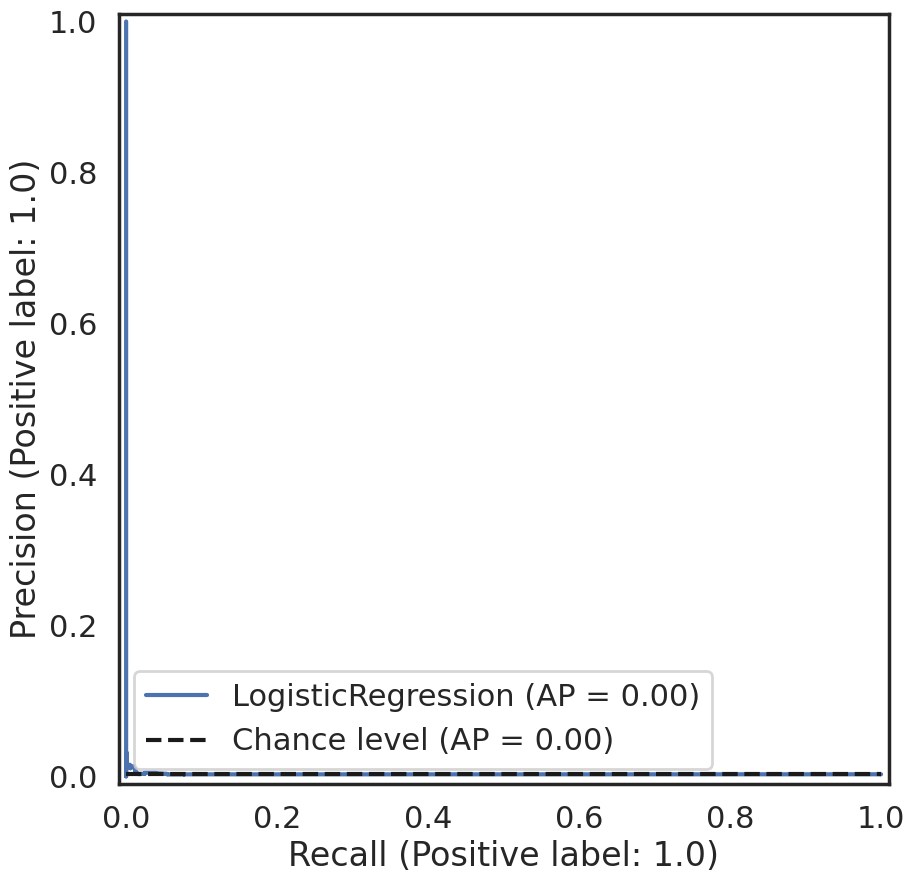

In [109]:
X_train, X_test, y_train, y_test = train_test_split(sadj, da, random_state=0, train_size=2_000_000)

clf = LogisticRegression(penalty="l1", C=1, solver="liblinear", class_weight={1:200,0:1}, max_iter=10_000, n_jobs=8)
clf.fit(X_train, y_train)
print("coef", clf.coef_)

pred = clf.predict(X_test)
print("precision", (pred[y_test==1]==1).sum()/(pred==1).sum())
print("random precision", y_test.sum()/len(y_test))
print("recall", (pred[y_test==1]==1).sum()/y_test.sum())
print("predicted true", pred.sum())
print("number of true", y_test.sum())
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, plot_chance_level=True)
plt.show()

base enrichment


Top central genes: []


2024-04-09 11:26:39,037 [WARNING] Duplicated values found in preranked stats: 99.97% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


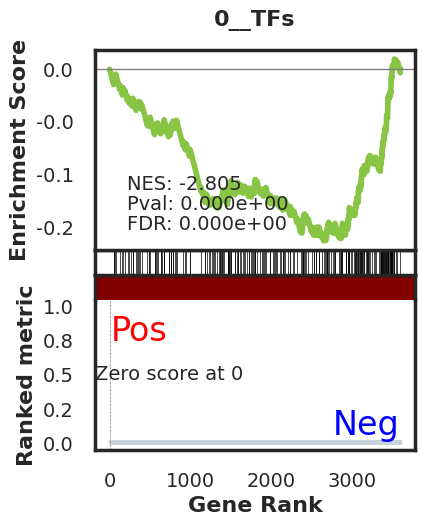

[]


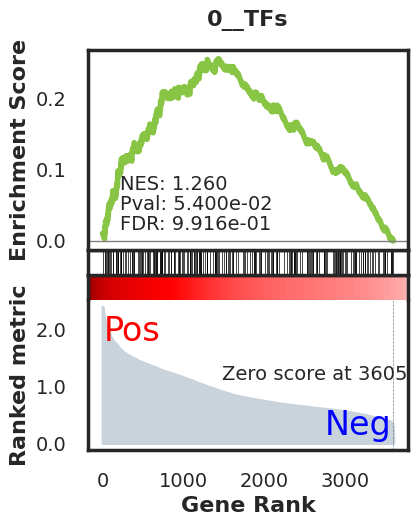

_________________________________________
TF specific enrichment


2024-04-09 11:26:41,667:INFO - Downloading and generating Enrichr library gene sets...
2024-04-09 11:26:41,670:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-09 11:26:41,856:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-09 11:26:41,867 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-09 11:26:42,098 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-09 11:26:42,343 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-09 11:26:42,593 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, whic

found!  0__SRF
0    1.035186
Name: NES, dtype: object




2024-04-09 11:26:44,665 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-09 11:26:44,948 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__RFX5
0    1.09728
Name: NES, dtype: object




2024-04-09 11:26:45,484 [WARNING] Duplicated values found in preranked stats: 0.17% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__EGR1
0    1.308172
Name: NES, dtype: object




2024-04-09 11:26:46,037 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-09 11:26:46,301 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-09 11:26:46,843 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-09 11:26:47,392 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-09 11:26:47,882 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__IRF3
0    1.040236
Name: NES, dtype: object




2024-04-09 11:26:48,160 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found some significant results for  14.814814814814815 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2585 genes
intersection pct: 0.7168607875762618
precision:  0.004099629015893163 
recall:  1.0 
random recall: 1.0


100%|██████████| 49/49 [00:00<00:00, 71.09it/s]


Area Under Precision-Recall Curve (AUPRC):  0.003558308458546723
random precision is:  0.004099629015893163
overal increase: (mean, max) (-2.415496932695549e-05, 7.823104478422413e-05)
true_positive 39
True Negative:  2529539.0
False Positive:  10407
False Negative:  10426
Odds Ratio:  0.9092068761506439


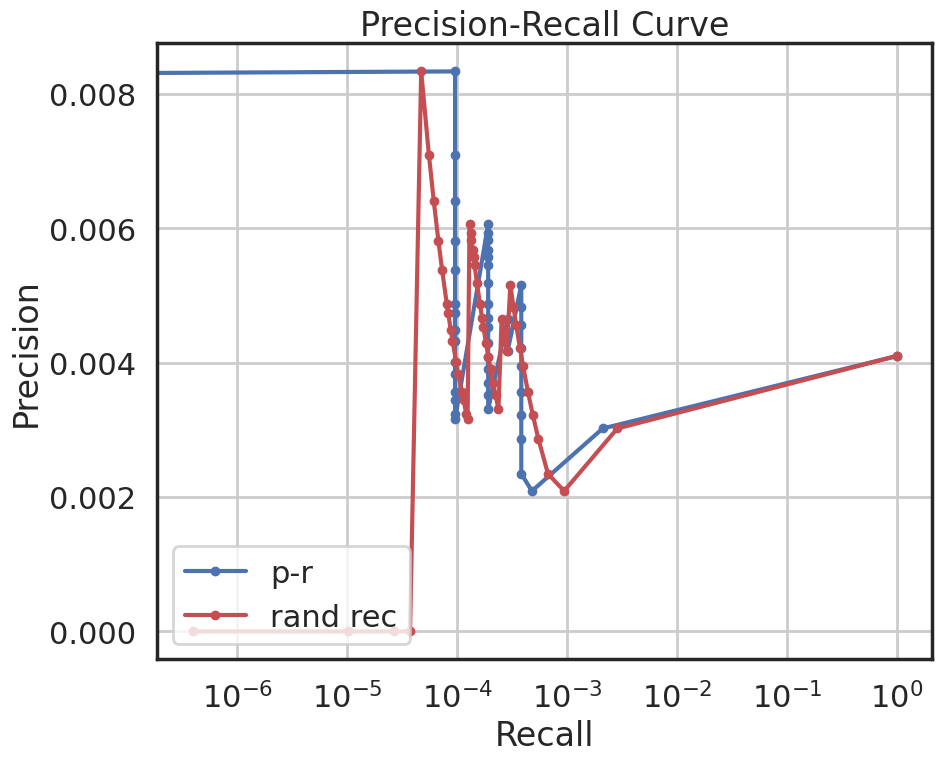

{'significant_enriched_TFtargets': 14.814814814814815,
 'auprc': 0.003558308458546723,
 'pr_increase_to_random': (-2.415496932695549e-05, 7.823104478422413e-05)}

In [ ]:
BenGRN(grn).scprint_benchmark()

In [ ]:
BenGRN(grn, doplot=True).compare_to(other=preadata)

intersection of 820 genes
intersection pct: 0.2273987798114254

intersection pct: 0.2273987798114254
> /home/ml4ig1/Documents code/benGRN/bengrn/base.py(188)compare_to()
    186 
    187         pdb.set_trace()
--> 188         if self.doplot:
    189             print(
    190                 "precision: ",

121278
(492, 492)
*** AttributeError: 'set' object has no attribute 'shape'
568
      source    target  weight
62    JARID2  ARHGAP10       1
69    JARID2     CDK14       1
70    JARID2    CELSR2       1
73    JARID2   CYP26A1       1
74    JARID2      ETV4       1
...      ...       ...     ...
2533    TCF3    ZNF706       1
2534    TCF3    ZNF821       1
2535    TCF3   ZSCAN10       1
2540   ZFP42     CCNT2       1
2543   ZFP42      ETS1       1

[568 rows x 3 columns]
(568,)
9


# overlap to gt network

In [ ]:
gt = preadata.grn[(preadata.grn.sum(0)!=0)]
gt = gt.loc[:, gt.sum() > 0]
res = []
for k, v in zip(*np.where(gt!=0)):
    res.append([gt.index[k], gt.columns[v], 1])
res = pd.DataFrame(res, columns=['source', 'target', 'weight'])

In [ ]:
from bengrn.base import get_GT_db
gt = get_GT_db(name="omnipath")

In [ ]:
278000/len(varnames2)**2 

0.000772683634547279

In [ ]:
varnames2 = set(gt.iloc[:, :2].values.flatten())
varnames = set(res.iloc[:, :2].values.flatten())
intersection = varnames & varnames2

In [ ]:
sroy = set([frozenset([i,j]) for i,j in res.iloc[:, :2].values if i in intersection and j in intersection])
omni = set([frozenset([i,j]) for i,j in gt.iloc[:, :2].values if i in intersection and j in intersection])
len(sroy), len(omni)


(1871, 4128)

In [ ]:
precision = len(sroy & omni) / len(sroy)
recall = len(sroy & omni) / len(omni)
rand = len(sroy) / (((len(intersection) ** 2) / 2) + (len(intersection) / 2))
print(
    "precision: ",
    precision,
    "\nrecall: ",
    recall,
    "\nrandom recall:",
    rand,
)

precision:  0.07215392838054516 
recall:  0.032703488372093026 
random recall: 0.0021427401649829762 0.07215392838054516 
recall:  0.032703488372093026 
random recall: 0.0021427401649829762
